
# **Project 2: Kaggle Text to Emotion Dataset 2**

In [1]:
# @title Import Libraries
import numpy as np
import pandas as pd
# Controlla se siamo in un ambiente Jupyter
try:
    get_ipython()
    %matplotlib inline
except:
    pass
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import string
import torch
from sklearn.metrics.pairwise import cosine_similarity
from unidecode import unidecode
import contractions
import emoji

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

url = 'https://raw.githubusercontent.com/AndreCanto00/Tweets_to_Emotions/main/tweet_emotions.csv'

def load_data(url):
    return pd.read_csv(url)

data = load_data(url)

In [3]:
#@title Init Variables

category_counts = {'neutral': 0,'worry': 0,'happiness': 0,'sadness': 0,'love': 0,'surprise': 0,'fun': 0,'relief': 0,'hate': 0,'empty': 0,'enthusiasm': 0,'boredom': 0,'anger': 0}

categories = ['neutral','worry','happiness','sadness','love','surprise','fun','relief','hate','empty','enthusiasm','boredom','anger']

In [4]:
from src.preprocessing import prepreprocess_data
df = prepreprocess_data(data)

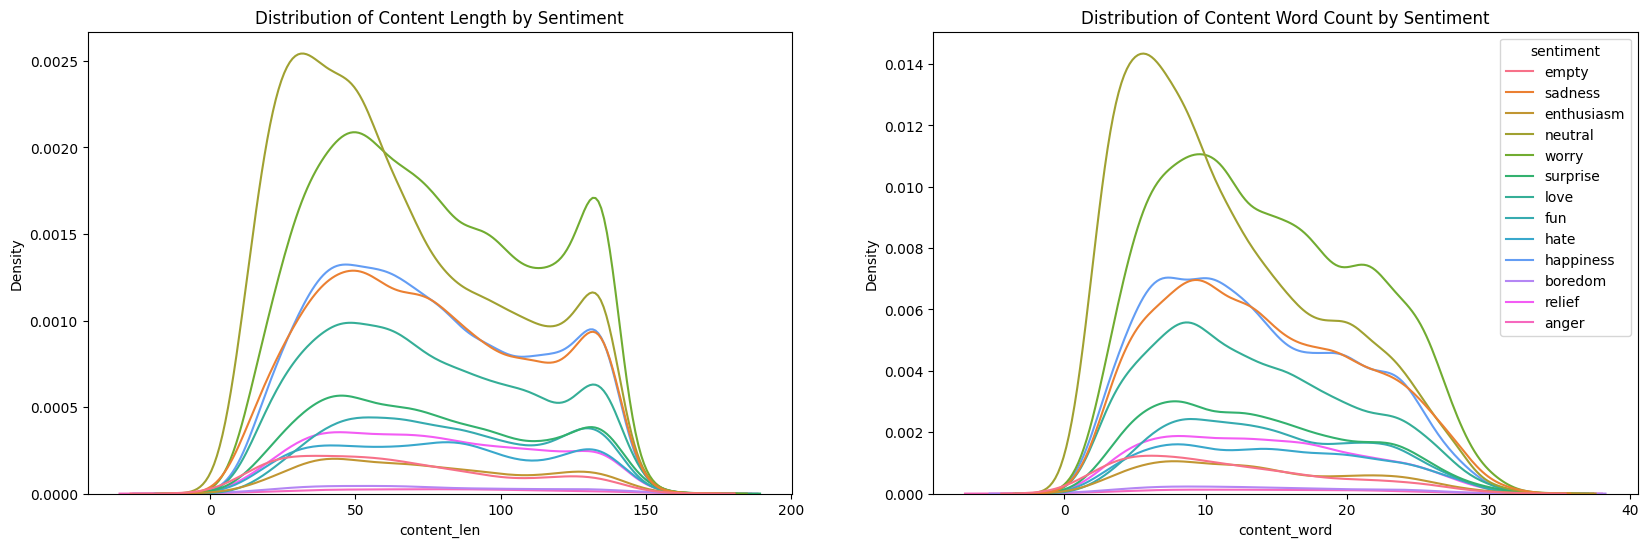

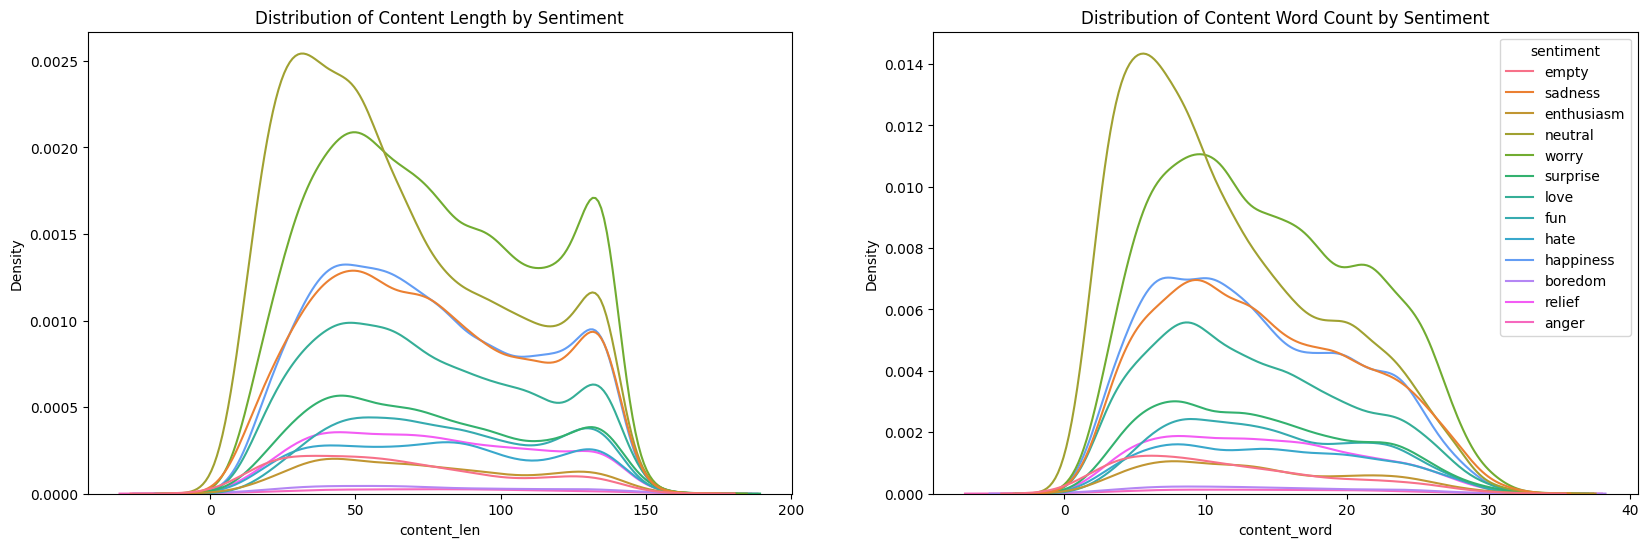

In [5]:
from src.visualization import plot_content_distributions

plot_content_distributions(df)

In [6]:
from src.preprocessing import get_dataframe_info

get_dataframe_info(df)

{'num_rows': 40000,
 'num_columns': 5,
 'column_names': ['tweet_id',
  'sentiment',
  'content',
  'content_len',
  'content_word'],
 'dtypes': {'tweet_id': dtype('int64'),
  'sentiment': dtype('O'),
  'content': dtype('O'),
  'content_len': dtype('int64'),
  'content_word': dtype('int64')},
 'non_null_counts': {'tweet_id': 40000,
  'sentiment': 40000,
  'content': 40000,
  'content_len': 40000,
  'content_word': 40000}}

## 1. Initial exploration:

In [7]:
from src.preprocessing import preprocess_data

# Applica il preprocessing al dataframe
data = preprocess_data(data)



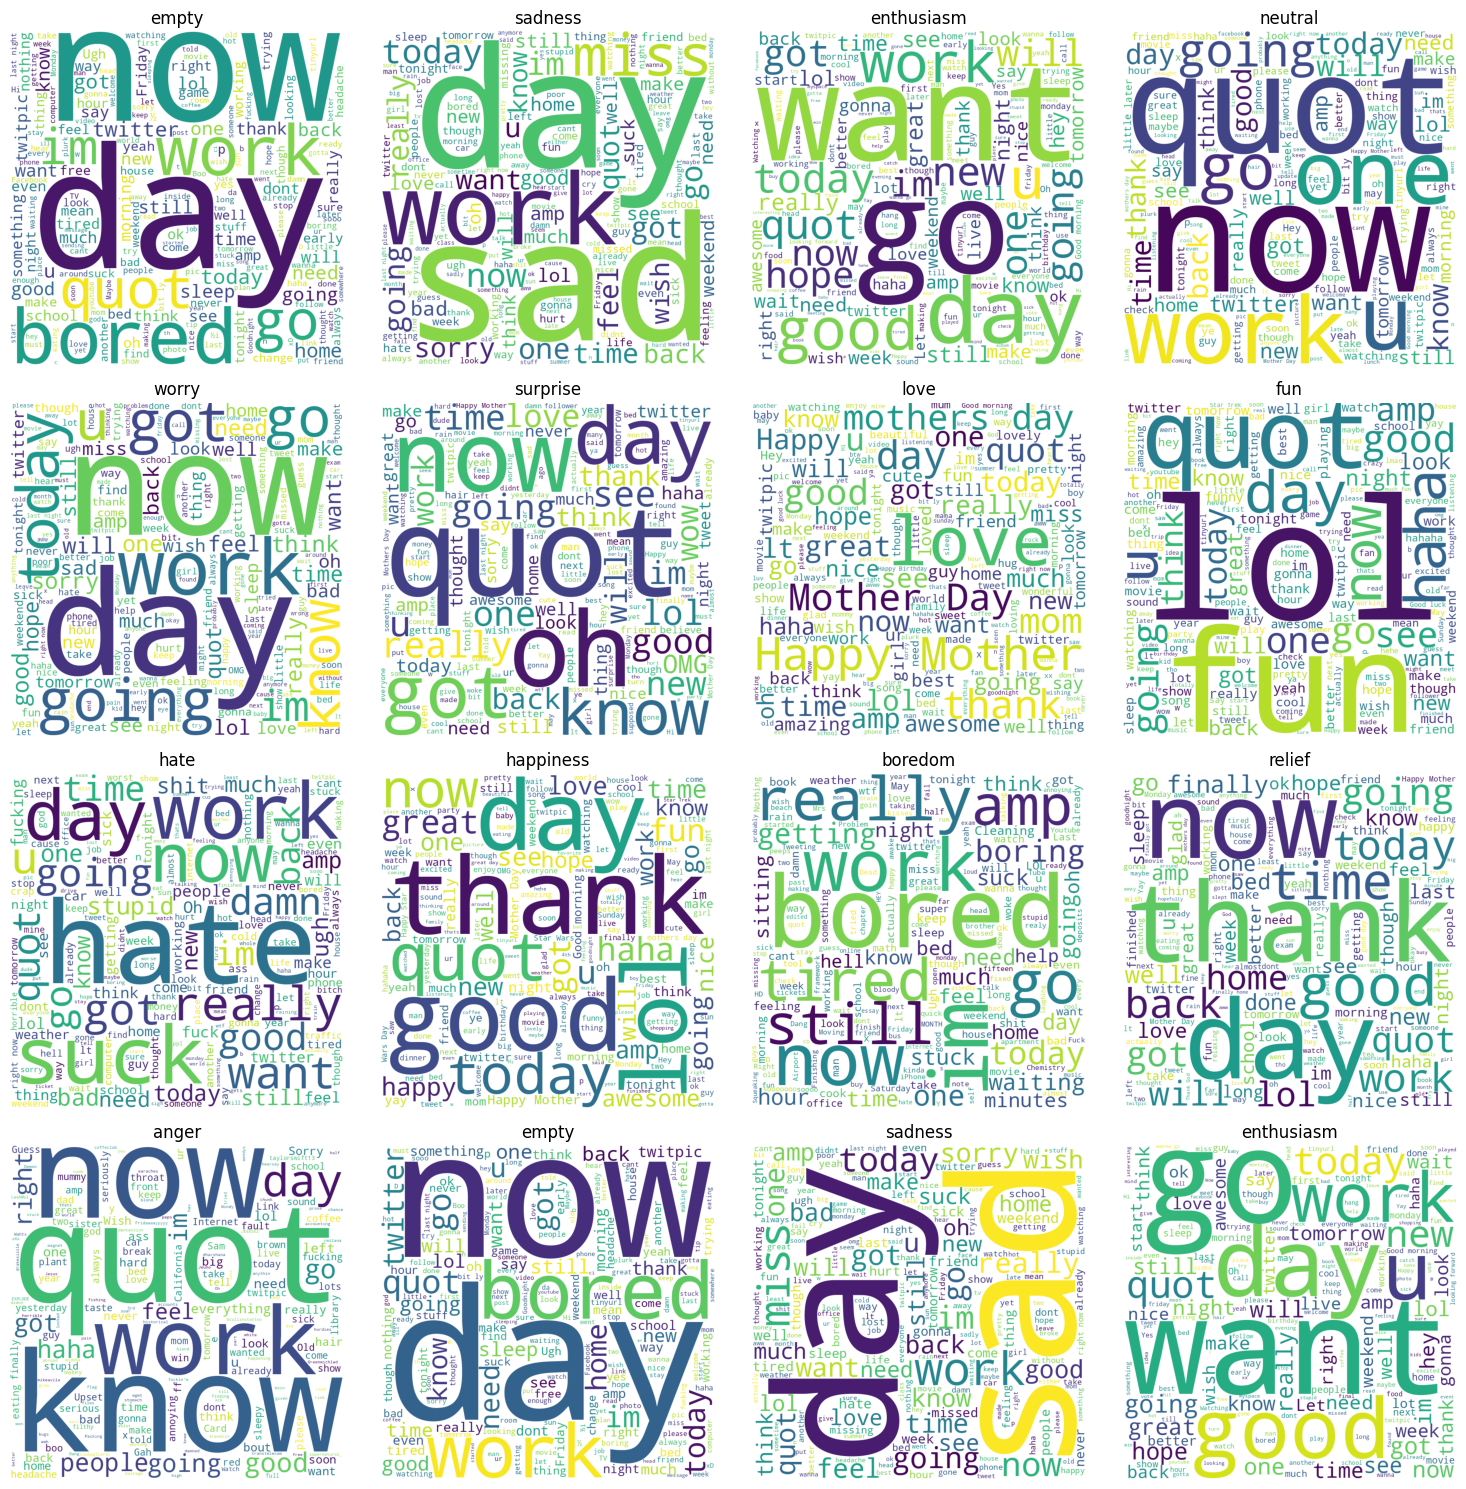

In [8]:
from src.visualization import plot_sentiment_wordclouds

plot_sentiment_wordclouds(data)


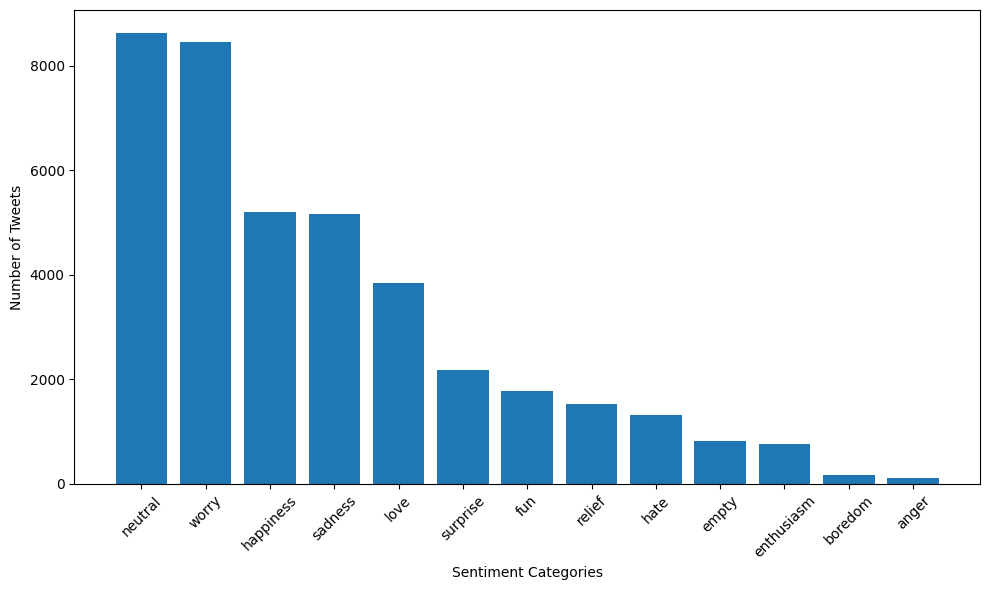

In [9]:
from src.visualization import plot_sentiment_histogram

plot_sentiment_histogram(data, category_counts)

## 2. Dataframes:
Write a script that **concatenates all tweets of the same category** and **put them on a single file** (data frame). Then use **Empath categorization** https://github.com/Ejhfast/empath-client, to **output the key categorizes of each dataframe**. Suggest a way to evaluate the matching between the categorizes generated by empath-category software and the labelling of the category in Twitter dataset (for each dataframe). Comment on the matching between the empath-category result and category title of each dataframe.

In [10]:
from src.tweet_categorization import create_category_tweets


category_tweets = create_category_tweets(data)

In [11]:
from src.tweet_categorization import save_categorized_tweets

concatenated_df = save_categorized_tweets(category_tweets, concatenated=True)
detached_df = save_categorized_tweets(category_tweets, concatenated=False)

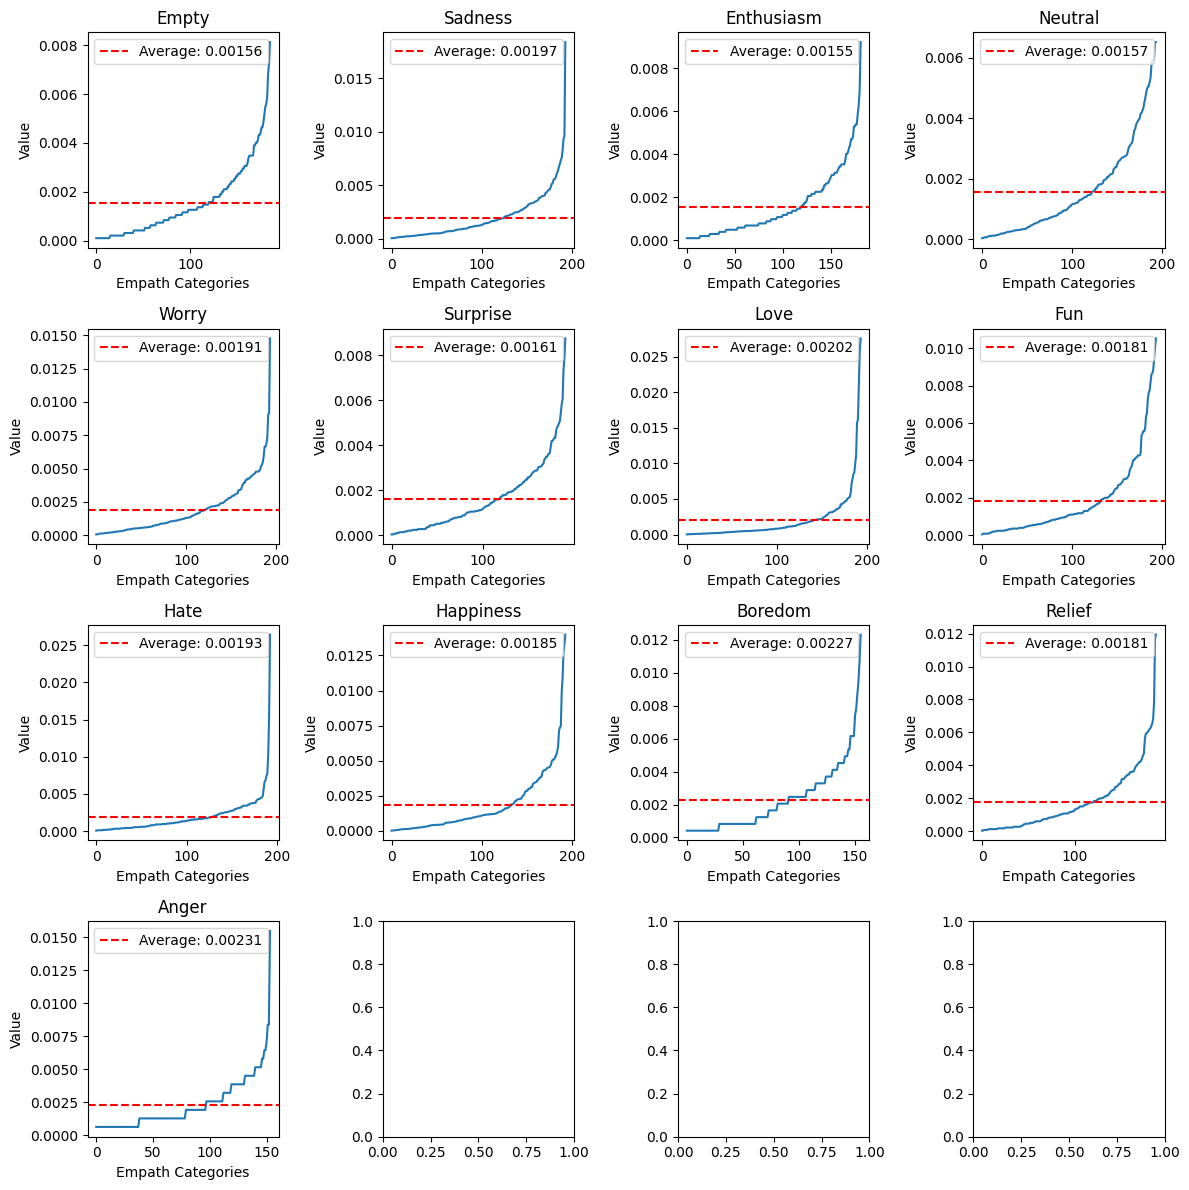

In [ ]:
from src.tweet_categorization import analyze_empath_categories
from src.visualization import plot_empath_analysis

# Analyze tweets
df, media, positive_values = analyze_empath_categories("concatenated_tweets_by_category.csv")

# Create visualization
fig = plot_empath_analysis(positive_values, media)
plt.show()

## vedi medie differenti

In [13]:
# Get key categories and analyze WordNet relationships
from src.tweet_categorization import get_key_categories

concatenated_df = get_key_categories(concatenated_df, media)
print(concatenated_df[['Sentiment Category', 'Key Categories']])

   Sentiment Category                                     Key Categories
0               empty  office money domestic_work sleep cold hate fam...
1             sadness  money wedding domestic_work sleep cold hate fa...
2          enthusiasm  money wedding domestic_work sleep cold family ...
3             neutral  office dance money wedding domestic_work sleep...
4               worry  money wedding domestic_work sleep medical_emer...
5            surprise  dance money wedding domestic_work sleep cold h...
6                love  dance wedding domestic_work sleep cold cheerfu...
7                 fun  dance wedding domestic_work sleep cold family ...
8                hate  office money domestic_work sleep cold hate env...
9           happiness  dance wedding domestic_work sleep cold cheerfu...
10            boredom  wedding domestic_work sleep cold hate family v...
11             relief  wedding domestic_work sleep cold hate family v...
12              anger  domestic_work sleep cold hat

In [ ]:
# Analyze WordNet relationships
from src.tweet_categorization import analyze_wordnet_relationships

results_df = analyze_wordnet_relationships(concatenated_df)
print(results_df)

## Vedi differenze

   Sentiment Category  Same Category Hyponyms               Hypernyms
0               empty          False                                 
1             sadness           True                                 
2          enthusiasm          False                                 
3             neutral          False                                 
4               worry          False           fear, business, eating
5            surprise          False                                 
6                love           True     love                    love
7                 fun           True                                 
8                hate           True                                 
9           happiness          False                     cheerfulness
10            boredom          False                                 
11             relief          False                                 
12              anger          False                                 


## 3.	LDA Topic Modelling

Instead of using the Empath categorization, we want to **use topic modelling to handle the category-record matching**. For this purpose, write a script that uses **LDA topic modelling with one topic and 3 words per topic**. For each dataframe, we would like to investigate this matching by studying the mapping between the three keywords generated by the LDA and title category. We want to study this mapping at two levels: string matching and semantic analysis. Write a script that tests for each dataframe,

  1. whether one of the generated keyword is the same as the tile category;  
  
  2. whether on or more of these keywords are hyponym or hypernym of the title category.
  
  Present the result in a table that summarizes the result for all dataframes.   

In [ ]:
from src.topic_modeling import analyze_lda_relationships, save_results_to_csv

# Load data
concatenated_df = pd.read_csv("concatenated_tweets_by_category.csv")

# Perform analysis
results_df = analyze_lda_relationships(concatenated_df)

# Display results
print(results_df)

# Save results
save_results_to_csv(results_df, "lda_analysis_results.csv")

In [ ]:
#@title LDA keywords

concatenated_df = pd.read_csv("concatenated_tweets_by_category.csv")
n_topics = 1
n_words_per_topic = 3
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

results = []
for index, row in concatenated_df.iterrows():
    sentiment_category = row['Sentiment Category']
    concatenated_tweets = row['Concatenated Tweets']

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([concatenated_tweets])
    lda.fit(X)
    topic_keywords = [vectorizer.get_feature_names_out()[i] for i in lda.components_.argsort()[:, -n_words_per_topic:]]
    result = {
        'Sentiment Category': sentiment_category,
        'LDA Keywords': topic_keywords
    }
    results.append(result)


results_df = pd.DataFrame(results)
print(results_df)

   Sentiment Category           LDA Keywords
0               empty       [[go, get, day]]
1             sadness     [[miss, sad, day]]
2          enthusiasm     [[good, go, want]]
3             neutral    [[get, going, day]]
4               worry    [[day, going, get]]
5            surprise       [[oh, get, day]]
6                love   [[happy, day, love]]
7                 fun    [[going, fun, lol]]
8                hate   [[like, suck, hate]]
9           happiness   [[happy, good, day]]
10            boredom    [[go, work, bored]]
11             relief  [[thanks, good, day]]
12              anger   [[going, know, get]]


In [ ]:
#@title Same Category, Hyponyms, Hypernyms

wnl = WordNetLemmatizer()
concatenated_df = pd.read_csv("concatenated_tweets_by_category.csv")

n_topics = 1
n_words_per_topic = 3
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
results = []

for index, row in concatenated_df.iterrows():
    sentiment_category = row['Sentiment Category']
    concatenated_tweets = row['Concatenated Tweets']
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([concatenated_tweets])
    lda.fit(X)

    topic_keywords = [vectorizer.get_feature_names_out()[i] for i in lda.components_.argsort()[:, -n_words_per_topic:]]
    is_same_category = sentiment_category in topic_keywords[0]

    hyponyms = []
    hypernyms = []
    for keyword in topic_keywords[0]:
      synsets_keyword = wordnet.synsets(keyword)
      synsets_category = wordnet.synsets(sentiment_category)
      for synset_keyword in synsets_keyword:
          for synset_category in synsets_category:
            if synset_keyword.hyponyms() and synset_category in synset_keyword.hyponyms():
                hyponyms.append(keyword)
            elif synset_keyword.hypernyms() and synset_category in synset_keyword.hypernyms():
                hypernyms.append(keyword)
    result = {
        'Sentiment Category': sentiment_category,
        'LDA Keywords': topic_keywords[0],
        'Same Category': is_same_category,
        'Hyponyms' : ', '.join(hyponyms),
        'Hypernyms': ', '.join(hypernyms)
    }

    results.append(result)


results_df = pd.DataFrame(results)
print(results_df)

   Sentiment Category         LDA Keywords  Same Category Hyponyms Hypernyms
0               empty       [go, get, day]          False                   
1             sadness     [miss, sad, day]          False                   
2          enthusiasm     [good, go, want]          False                   
3             neutral    [get, going, day]          False                   
4               worry    [day, going, get]          False                   
5            surprise       [oh, get, day]          False                   
6                love   [happy, day, love]           True     love      love
7                 fun    [going, fun, lol]           True                   
8                hate   [like, suck, hate]           True                   
9           happiness   [happy, good, day]          False                   
10            boredom    [go, work, bored]          False                   
11             relief  [thanks, good, day]          False                   

## 4.	BerTopic

Instead of using LDA, we use another state-of-the-art topic modelling technique based on transformer: **BerTopic**, see https://github.com/MaartenGr/BERTopic. Study the example provided in github and **suggest how you will proceed to imitate the reasoning of 3) or 2) to test whether the BERTopic generated topics match with the category title of each dataframe**. Use the illustration provided in BERTopic to draw the result of this topic modelling. Summarize the result in a table.  

In [ ]:
#@title BerTopic FIT

from bertopic import BERTopic

cat_tweets = {}
model_list = {}

for index, row in detached_tweets_df.iterrows():
  sentiment_category = row['Sentiment Category']
  tweets = row['Tweets']

  cat_tweets[sentiment_category] = {}
  topic_model = BERTopic()
  topics, probs = topic_model.fit_transform(tweets)
  cat_tweets[sentiment_category] = [topics, probs]
  model_list[sentiment_category] = topic_model

In [ ]:
#@title Key Categories finding by BerTopic for Each DataFrame

probability_array = {}
for sentiment_category, values in cat_tweets.items():
    topics, probs = values

    probability_array[sentiment_category] = {}
    for topic, prob in zip(topics, probs):
      if topic not in probability_array[sentiment_category]: #init
        probability_array[sentiment_category][topic] = [0,0]

      pre_topic, pre_prob = probability_array[sentiment_category][topic]
      probability_array[sentiment_category][topic] = [pre_topic + 1, pre_prob + prob]

In [ ]:
#@title Ranking Topics + ordering

tot_tweet = {}

rank = {}
for sentiment_category, i in probability_array.items():
  tot_tweet[sentiment_category] = sum([valore[0] for valore in probability_array[sentiment_category].values()])

  rank[sentiment_category] = {}
  for topic in probability_array[sentiment_category]:
    tweet, prob = probability_array[sentiment_category][topic]
    perc_tweets = tweet/tot_tweet[sentiment_category]
    perc_prob = prob/tweet
    rank[sentiment_category][topic] = perc_tweets*perc_prob*100

ordered_rank = {}
for sentiment_cat in rank:
  ordered_rank[sentiment_cat] = dict(sorted(rank[sentiment_cat].items(), key=lambda item: item[1], reverse=True))

In [ ]:
ordered_rank['happiness']

{0: 4.385168478753298,
 1: 4.23921698813503,
 3: 2.0971532372962156,
 2: 1.8582253154045305,
 5: 1.4370567493120485,
 4: 0.9394017820471497,
 10: 0.9080373572985568,
 7: 0.8515810666686332,
 6: 0.8471795765019252,
 9: 0.8290815724219854,
 15: 0.8071388214559404,
 19: 0.7418387820977513,
 12: 0.720591671931148,
 8: 0.7162890928933664,
 23: 0.7071697132911993,
 11: 0.6987667709459121,
 13: 0.6491676493418047,
 25: 0.6141520423883771,
 20: 0.5935541564806569,
 26: 0.5833252911323128,
 14: 0.5831778379711822,
 16: 0.5618190972050706,
 22: 0.5383160885167932,
 36: 0.5146438333464689,
 18: 0.489824304048923,
 27: 0.48419476639036463,
 42: 0.46555137643456374,
 34: 0.4652672627428337,
 24: 0.45441999070242617,
 37: 0.4503709323212676,
 28: 0.4489585294153821,
 40: 0.44502417385499987,
 29: 0.4413964700708841,
 21: 0.4338092558797149,
 38: 0.4318969898351398,
 41: 0.43175232850802686,
 17: 0.42730105811372665,
 39: 0.4224933480874539,
 31: 0.41485369738829114,
 30: 0.3984625619531444,
 48: 0.3

In [ ]:
#@title Category Title is in Topic?

category_in_topic = {}
for sentiment_cat in ordered_rank:
  category_in_topic[sentiment_cat] = []
  for topic, prob in ordered_rank[sentiment_cat].items():
    if any(sentiment_cat in tupla for tupla in model_list[sentiment_cat].get_topic(topic)):
      category_in_topic[sentiment_cat].append([topic, prob])

category_in_topic

{'empty': [],
 'sadness': [[12, 0.9110043005680591]],
 'enthusiasm': [],
 'neutral': [],
 'worry': [[82, 0.193119093499002]],
 'surprise': [],
 'love': [[0, 2.409059986801207],
  [1, 0.9373458011907596],
  [15, 0.8107882351207348],
  [-1, 0.0]],
 'fun': [[0, 98.8834190980891]],
 'hate': [[1, 2.7874859470430926],
  [9, 2.7087259164725137],
  [5, 2.63113677953055],
  [-1, 0.0]],
 'happiness': [[20, 0.5935541564806569]],
 'boredom': [],
 'relief': [],
 'anger': []}

In [ ]:
for sentiment_cat in model_list:
  try:
      model_list[sentiment_cat].visualize_topics()
  except Exception as e:
      print(sentiment_cat, " too less elements")

empty  too less elements
fun  too less elements


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



boredom  too less elements
anger  too less elements


In [ ]:
model_list["sadness"].visualize_topics()

##5. FuzzyWuzzy Redundancy and Diversity Evaluation

We want to **evaluate the extent of redundancy and diversity** present in each dataframe. For this purpose, we start by looking into string matching. Use the **fuzzywuzzy** string matching package to calculate the ratio score of every pair (without repetition) of records belonging to the same category (data frame). Report the minimum, maximum and average ratio score (percentage indicating the amount of overlapping in terms of edit distance) for each data frame. A high minimum ration score indicates a high redundancy of elements of the class, while a small value may indicate high diversity.

In [ ]:
from fuzzywuzzy import fuzz


def calculate_ratio_scores(strings_list):
    ratio_scores = []
    for i in range(len(strings_list)):
        for j in range(i + 1, len(strings_list)):
            ratio = fuzz.ratio(strings_list[i], strings_list[j])
            ratio_scores.append(ratio)
    return ratio_scores

result_data = []
ratios = {}
for i in range(13):
  sentiment_category = detached_tweets_df.iloc[i,0]
  tweets = detached_tweets_df.Tweets[i]

  ratio_scores = calculate_ratio_scores(tweets)

  if ratio_scores:
      ratios[sentiment_category] = ratio_scores
      result_data.append({
          'Sentiment Category': sentiment_category,
          'Min Ratio Score': min(ratio_scores),
          'Max Ratio Score': max(ratio_scores),
          'Average Ratio Score': sum(ratio_scores) / len(ratio_scores)
      })


result_df = pd.DataFrame(result_data)
print(result_df)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


0
1
2
3
4
5
6
7
8
9
10
11
12
   Sentiment Category  Min Ratio Score  Max Ratio Score  Average Ratio Score
0               empty                0              100            20.922199
1             sadness                0              100            23.184607
2          enthusiasm                0              100            23.353534
3             neutral                0              100            21.286327
4               worry                0              100            23.089838
5            surprise                0              100            22.452114
6                love                0              100            23.685865
7                 fun                0              100            23.359739
8                hate                0              100            23.128313
9           happiness                0              100            23.181408
10            boredom                0               65            24.431297
11             relief                0         

## 6. FuzzyWuzzy Diversity Evaluation Pro

To further elucidate the extent of diversity using **FuzzyWuzzy** metric, consider a subdivision of the ratio score between the minimum value and the maximum value into 10 equally separated threshold values, and write a script that identifies the number of (couple of???) records whose FuzzyWuzzy ration scores is beyond the corresponding threshold. Suggest a graphical illustration of your choice to illustrate this result. Repeat this process for each data frame. Comment on the extend of diversity & redundancy present in each dataframe.

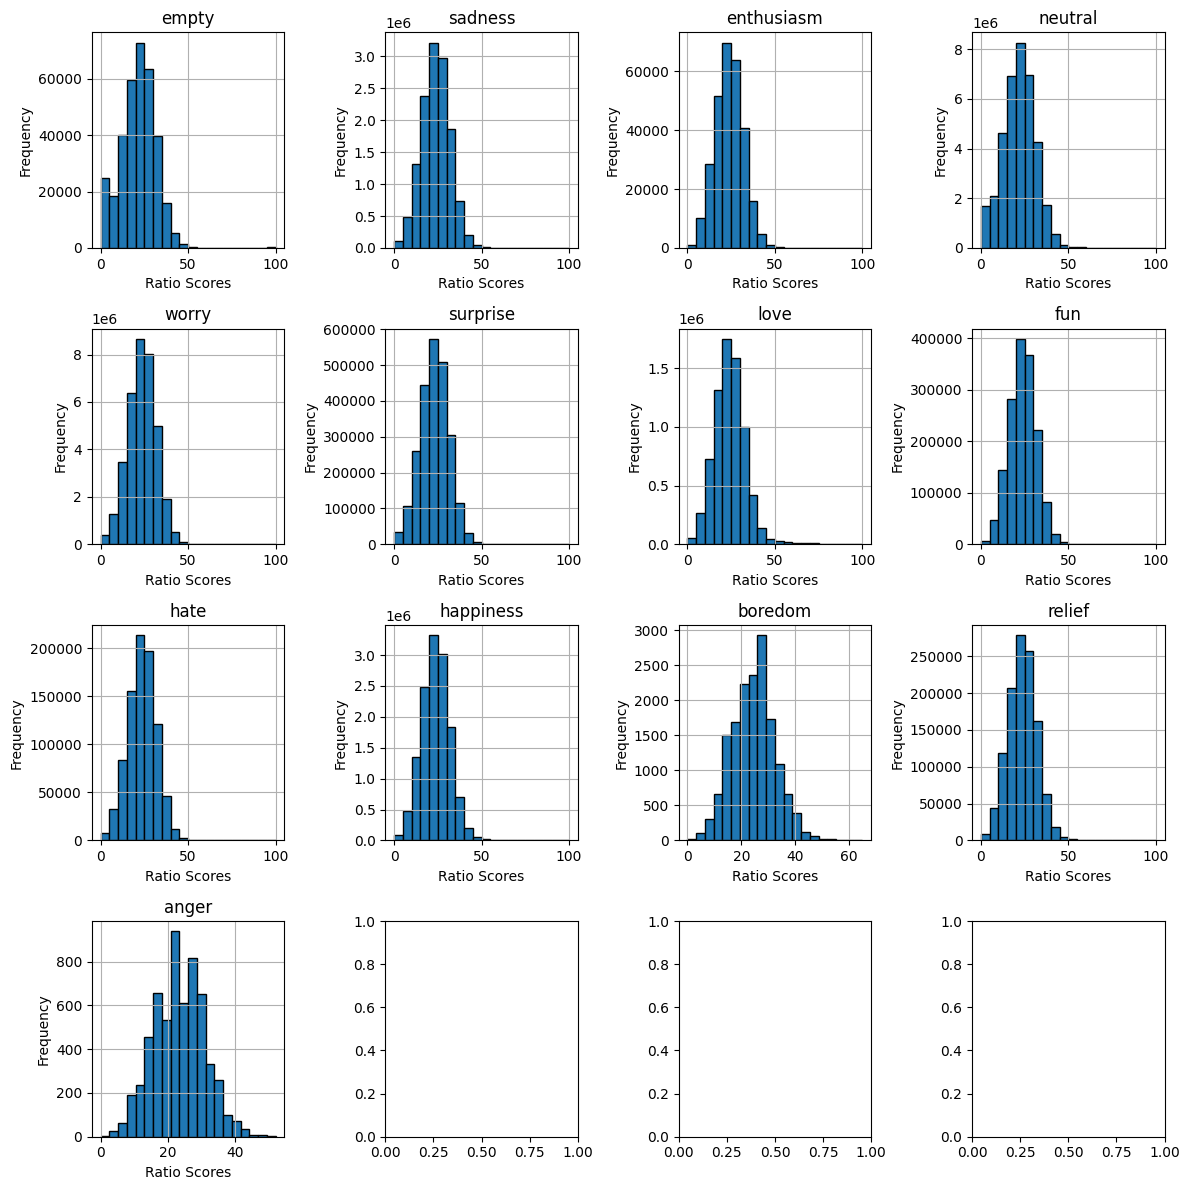

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(13):
    row, col = i // 4, i % 4
    sentiment_category = result_df['Sentiment Category'][i]
    ratio_scores_category = ratios[sentiment_category]

    axs[row, col].hist(ratio_scores_category, bins=20, edgecolor='k')
    axs[row, col].set_xlabel('Ratio Scores')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(sentiment_category)
    axs[row, col].grid(True)


plt.tight_layout()
plt.show()

Intervallo 1: Range (0.00 - 10.00): 42902 dati (12.56%)
Intervallo 2: Range (10.00 - 20.00): 99427 dati (29.11%)
Intervallo 3: Range (20.00 - 30.00): 136056 dati (39.83%)
Intervallo 4: Range (30.00 - 40.00): 55678 dati (16.30%)
Intervallo 5: Range (40.00 - 50.00): 6471 dati (1.89%)
Intervallo 6: Range (50.00 - 60.00): 538 dati (0.16%)
Intervallo 7: Range (60.00 - 70.00): 88 dati (0.03%)
Intervallo 8: Range (70.00 - 80.00): 21 dati (0.01%)
Intervallo 9: Range (80.00 - 90.00): 1 dati (0.00%)
Intervallo 10: Range (90.00 - 100.00): 369 dati (0.11%)
Intervallo 1: Range (0.00 - 10.00): 594542 dati (4.46%)
Intervallo 2: Range (10.00 - 20.00): 3692766 dati (27.69%)
Intervallo 3: Range (20.00 - 30.00): 6186270 dati (46.39%)
Intervallo 4: Range (30.00 - 40.00): 2592101 dati (19.44%)
Intervallo 5: Range (40.00 - 50.00): 250587 dati (1.88%)
Intervallo 6: Range (50.00 - 60.00): 16881 dati (0.13%)
Intervallo 7: Range (60.00 - 70.00): 2110 dati (0.02%)
Intervallo 8: Range (70.00 - 80.00): 459 dati (0

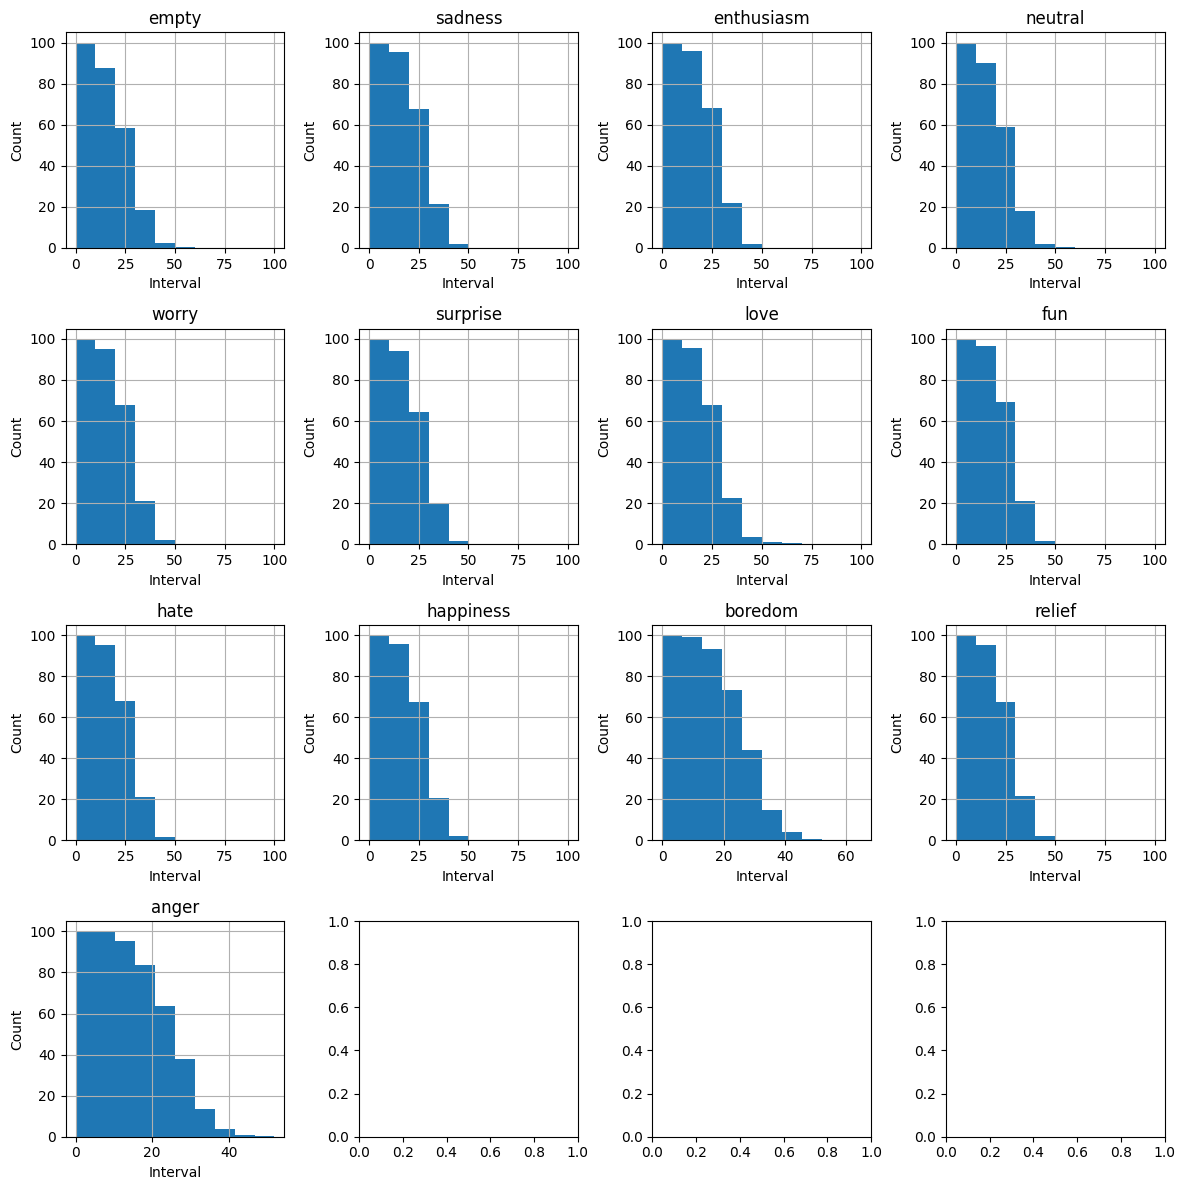

In [ ]:
#@title Plot FuzzyWuzzy Ratio Scores Beyond Threshold

import numpy as np
import matplotlib.pyplot as pl
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(13):
    row, col = i // 4, i % 4

    sentiment_category = result_df['Sentiment Category'][i]
    ratio_scores = ratios[sentiment_category]

    min_value = min(ratio_scores)
    max_value = max(ratio_scores)

    num_bins = 10
    bin_width = (max_value - min_value) / num_bins

    bins = [min_value + i * bin_width for i in range(num_bins)]
    bins.append(max_value)

    hist, bin_edges = np.histogram(ratio_scores, bins)
    total_data = len(ratio_scores)


    percentage = []

    for i in range(num_bins):
        percentage.append((hist[i] / total_data) * 100)
        print(f"Intervallo {i + 1}: Range ({bin_edges[i]:.2f} - {bin_edges[i + 1]:.2f}): {hist[i]} dati ({percentage[i]:.2f}%)")


    y_values = []
    for num in percentage[::-1]:
        if not y_values:
            y_values.append(num)
        else:
            y_values.append(y_values[-1] + num)

    axs[row, col].bar(bins[:-1], y_values[::-1], width=bin_width, align='edge')
    axs[row, col].set_xlabel('Interval')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_title(sentiment_category)
    axs[row, col].grid(True)



plt.tight_layout()
plt.show()

## 7. Proximity Evaluation with Antonym Relation
We want to evaluate the proximity between the different categories using the antonym relation. For this purpose, for each category Ci, identify using lexical database of your choice, the list of antonyms, say, Si1, Si2, …, Sin, and Sj1, Sj2, …,Sjm for categories Ci and Cj. Next, use the following construction: To evaluate the similarity between categories Ci and Cj, calculate the Wu and Palmer semantic similarity between category Ci (Cj) and each of antonym words Si1, Si2,…, Sin (Sj1, Sj2,…,Sjm) as follows: <br><br>Compare the results of the above construction and the simple Wu and Palmer similarity between Ci and Cj. Especially, discuss the discrepancy between the two models when looking for most similar category to each given category. Present the result in a table with a comparison with Wu & Palmer similarity.



In [12]:
#@title Antonyms Category Finder
def get_antonyms(word):
    antonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.antonyms():
                antonyms.extend([antonym.name() for antonym in lemma.antonyms()])
    return list(set(antonyms))

antonyms_category = {}
big_antonyms_category = {}

for category in categories:
  antonyms = get_antonyms(category)
  antonyms_category[category] = antonyms
  big_antonyms_category[category] = {}

  for synset_category in wordnet.synsets(category):
    big_antonyms_category[category][str(synset_category)] = []
    for lemma in synset_category.lemmas():
      for antonym in lemma.antonyms():
        big_antonyms_category[category][str(synset_category)].append(antonym.name())

In [13]:
#@title Sim(Ci, Cj) functions
def sim_between_categories(ci, cj, ci_antonyms, cj_antonyms):
  if not ci_antonyms and not cj_antonyms:
    return -1

  return 1 - 1/2 * (max_wup_similarity(ci, ci_antonyms) + max_wup_similarity(cj, cj_antonyms))

def max_wup_similarity(category, c_antonyms):
    max_sim = 0

    for ant in c_antonyms:
        for synset_category in wordnet.synsets(category):
            for synset_ant in wordnet.synsets(ant):
                similarity = synset_category.wup_similarity(synset_ant)
                if similarity is not None and similarity > max_sim:
                    max_sim = similarity

    return max_sim


In [ ]:
#@title Proximity Evaluation Between Categories

result = []
for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
      result.append( (categories[i], categories[j], sim_between_categories(categories[i], categories[j], antonyms_category[categories[i]], antonyms_category[categories[j]]) ) )

df = pd.DataFrame(result, columns=["Cat1", "Cat2", "Similarity"])
pivot_table = pd.pivot_table(df, values="Similarity", index="Cat1", columns="Cat2", fill_value="-")
print(pivot_table)

Cat2           anger   boredom     empty enthusiasm       fun happiness  \
Cat1                                                                      
boredom    -1.000000         -         -          -         -         -   
empty       0.666667  0.666667         -   0.666667         -         -   
enthusiasm -1.000000      -1.0         -          -         -         -   
fun        -1.000000      -1.0  0.666667       -1.0         -         -   
happiness   0.562500    0.5625  0.229167     0.5625    0.5625         -   
hate        0.571429  0.571429  0.238095   0.571429         -         -   
love        0.571429  0.571429  0.238095   0.571429  0.571429         -   
neutral     0.750000      0.75  0.416667       0.75      0.75    0.3125   
relief     -1.000000      -1.0  0.666667       -1.0         -         -   
sadness     0.583333  0.583333      0.25   0.583333  0.583333         -   
surprise   -1.000000      -1.0  0.666667       -1.0      -1.0         -   
worry       0.833333  0.8

## 8. Category Agreement with Antonyms, BERT Embeddings

We want **test the extent to which the records of each category agree with the antonym keywords**. For this purpose, for each category Ci, whose antonyms are Si1, Si2, ..,Sin,  write a script that uses (base) BERT-embedding vector of each record R and the embedding vector of anonyms as follows:


        Sim(C_i,R)=1-max┬(j=1,n)⁡(Cosine(BERT(R),BERT(Sij)))


where the cosine similarity between the two embedding vectors is the normalized measure. Identify the minimum, maximum and average Sim(C_i,R) over all records R of category Ci. Present the result in a table and comment on the agreement between the category labelling and antonym-based reasoning.   You may inspire from existing implementation in Kaggle that implements BERT model for classification purpose on the same dataset, provided in the initial link of this project description.



In [15]:
#@title BERT
from transformers import BertTokenizer, BertModel


# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embedding(text): # BERT
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs['last_hidden_state'].mean(dim=1).squeeze().numpy()

categories = antonyms_category
results_bert = {}

for category, antonyms in categories.items():
  if antonyms:
    category_embeddings = [get_bert_embedding(antonym) for antonym in antonyms]
    results_bert[category] = {}
    index = detached_tweets_df.index[detached_tweets_df['Sentiment Category'] == category].tolist()

    index = index[0]
    records = detached_tweets_df.at[index, 'Tweets']
    n = 0
    for record in records:
      record_embedding = get_bert_embedding(record)
      cosine_similarities = [ cosine_similarity([record_embedding], [antonym_embedding]) for antonym_embedding in category_embeddings ]
      if not cosine_similarities: max_cosine_similarity = 1
      else:
        max_cosine_similarity = 1 - max(cosine_similarities)
      results_bert[category][n] = max_cosine_similarity
      n +=1

In [16]:
results = []
for sentiment_category in results_bert.keys():
    similarities = results_bert[sentiment_category]
    avg = 0
    n = 0
    actual_max = 0
    actual_min = 2
    for similarity in similarities.values():
      if isinstance(similarity, np.ndarray):
        similarity = similarity
      avg += similarity
      n += 1
      if similarity > actual_max:
        actual_max = similarity
      if similarity < actual_min:
        actual_min = similarity

    result = {
        "Sentiment Category": sentiment_category,
        "Min": actual_min,
        "Max": actual_max,
        "Mean": avg/n,
    }

    results.append(result)

result_df = pd.DataFrame(results)
print(result_df)

  Sentiment Category              Min             Max            Mean
0            neutral    [[0.1952402]]  [[0.86300695]]  [[0.51770264]]
1              worry  [[0.050159514]]  [[0.88282895]]   [[0.5738891]]
2          happiness  [[0.122507036]]  [[0.71179783]]   [[0.4952303]]
3            sadness          [[0.0]]   [[0.8464868]]  [[0.53787965]]
4               love   [[0.10572612]]  [[0.83088225]]   [[0.5423489]]
5               hate   [[0.17603213]]   [[0.9101893]]  [[0.54661715]]
6              empty   [[0.07217467]]    [[0.822246]]  [[0.47716326]]


## 9.	Classification Rate

We want to devise a **classifier** that enhances the **classification rate of the various categories**. For this purpose, starting by a simple Random Forest classifier using 500 TF-IDF size as feature vector. You may inspire from the implementation of RoBERTa where a nice implementation of Logistic regression is detailed. **Use the 80-20 % split of training -testing and 10 fold cross validation to output the confusion matrix**.  Repeat the process when using **XGBoost classifier**, which in theory has some edge in handling imbalanced class dataset. Draw ROC graph to illustrate the performance of the classifier.



In [ ]:
#@title Library Import

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
import xgboost as xgb
from gensim.models import Word2Vec
from sklearn.metrics import mean_squared_error

In [ ]:
#@title Functions Init

def split_data(data):

  x = np.array(data['content'].values)
  y = np.array(data['sentiment'].values)

  encoder = LabelEncoder()
  y = encoder.fit_transform(y)
  labels = np.unique(encoder.inverse_transform(y))
  label_sentiment_mapping = {label: sentiment for label, sentiment in zip(np.unique(y), np.unique(data['sentiment']))}
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

  tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
  x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()
  x_test_tfidf = tfidf_vectorizer.transform(x_test).toarray()

  return x_train_tfidf, x_test_tfidf, y_train, y_test, labels, label_sentiment_mapping

def conf_matrix(y, y_pred, labels, title):
  fig, ax =plt.subplots(figsize=(10,10))
  ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":15})
  ax.xaxis.set_ticklabels(labels, fontsize=10)
  ax.yaxis.set_ticklabels(labels, fontsize=10)
  plt.title(title, fontsize=20)
  ax.set_ylabel('Test', fontsize=12)
  ax.set_xlabel('Predicted', fontsize=12)
  plt.show()

def RandomForest_grid(X, x, Y, y, l):

  params = {'n_estimators' : [5, 10, 15, 20, 25, 50, 100, 150],
    'criterion' : ['entropy', 'gini'],
             }

  classifier= RandomForestClassifier()
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
  grid = GridSearchCV(classifier, param_grid=params, cv=cv)

  grid.fit(X, Y)

  y_pred = grid.predict(x)
  accuracy = grid.score(x, y)

  return accuracy, grid.best_params_


In [ ]:

X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data(data)

accuracy, best_param = RandomForest_grid(X_train, X_test, y_train, y_test, labels)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Best parametrs: ', best_param)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Accuracy: 31.64%
Best parametrs:  {'criterion': 'gini', 'n_estimators': 150}


Accuracy on train: 83.22%
Accuracy on test: 31.46%

Classification Report:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.04      0.01      0.01       165
  enthusiasm       0.07      0.01      0.01       152
         fun       0.12      0.04      0.06       355
   happiness       0.28      0.34      0.31      1042
        hate       0.33      0.18      0.23       265
        love       0.43      0.37      0.40       768
     neutral       0.32      0.50      0.39      1728
      relief       0.20      0.05      0.08       305
     sadness       0.30      0.21      0.25      1033
    surprise       0.14      0.03      0.06       437
       worry       0.33      0.42      0.37      1692

    accuracy                           0.31      8000
   macro avg       0.20      0.17      0.17      8000
weighted avg       0.29      0.31      0.29      8000



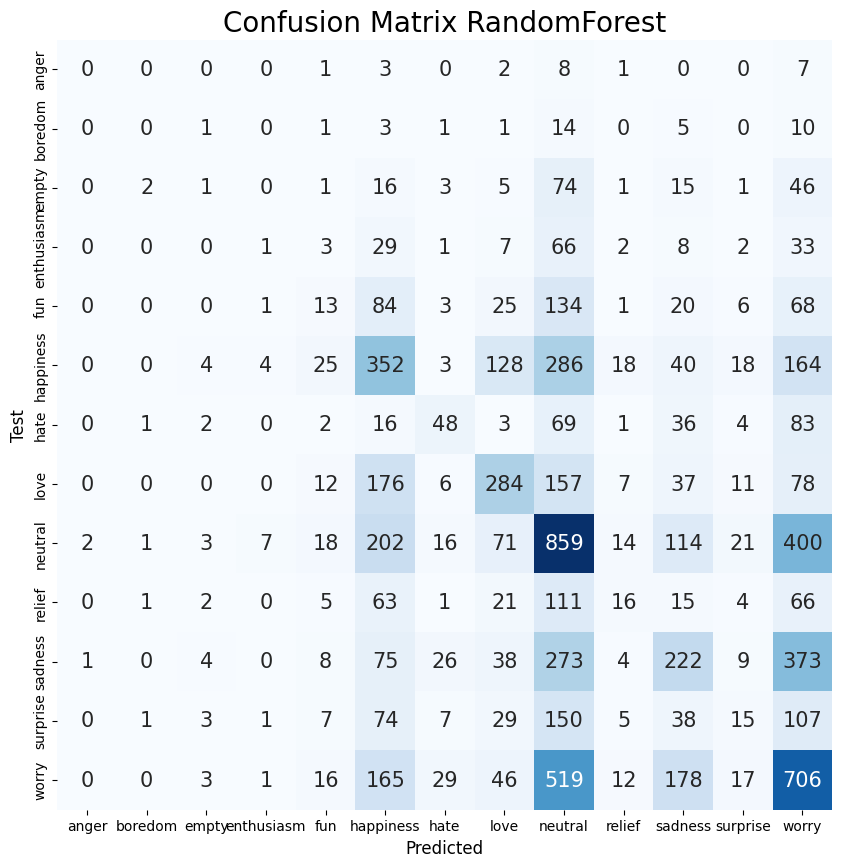

In [ ]:
def RandomForest_Train(X, x, Y, y, l):

  classifier= RandomForestClassifier()

  classifier = RandomForestClassifier(criterion = 'gini', n_estimators = 150)
  classifier.fit(X, Y)

  y_pred = classifier.predict(x)

  accuracy_test = classifier.score(x, y)
  accuracy_train = classifier.score(X, Y)

  return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data(data)

accuracy_test, accuracy_train, y, y_pred = RandomForest_Train(X_train, X_test, y_train, y_test, labels)


print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix RandomForest')

In [ ]:
def XGBoost_grid(X, x, Y, y, l):
    params = {
        'n_estimators': [100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }

    classifier = xgb.XGBClassifier(objective='multi:softmax')
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid = GridSearchCV(classifier, param_grid=params, cv=cv)

    grid.fit(X, Y)

    y_pred = grid.predict(x)
    accuracy = grid.score(x, y)

    return accuracy, grid.best_params_

X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data(data)

accuracy, best_params = XGBoost_grid(X_train, X_test, y_train, y_test, labels)
print('XGBoost Accuracy: {:.2f}%'.format(accuracy * 100))
print('Best Parameters: ', best_params)

XGBoost Accuracy: 33.17%
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


Accuracy on train: 39.99%
Accuracy on test: 33.17%

Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.09      0.01      0.02       355
   happiness       0.33      0.27      0.30      1042
        hate       0.44      0.21      0.29       265
        love       0.50      0.39      0.44       768
     neutral       0.30      0.72      0.42      1728
      relief       0.29      0.03      0.06       305
     sadness       0.39      0.18      0.25      1033
    surprise       0.24      0.03      0.05       437
       worry       0.34      0.34      0.34      1692

    accuracy                           0.33      8000
   macro avg       0.22      0.17      0.17      8000
weighted avg       0.32      0.33      0.29      8000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


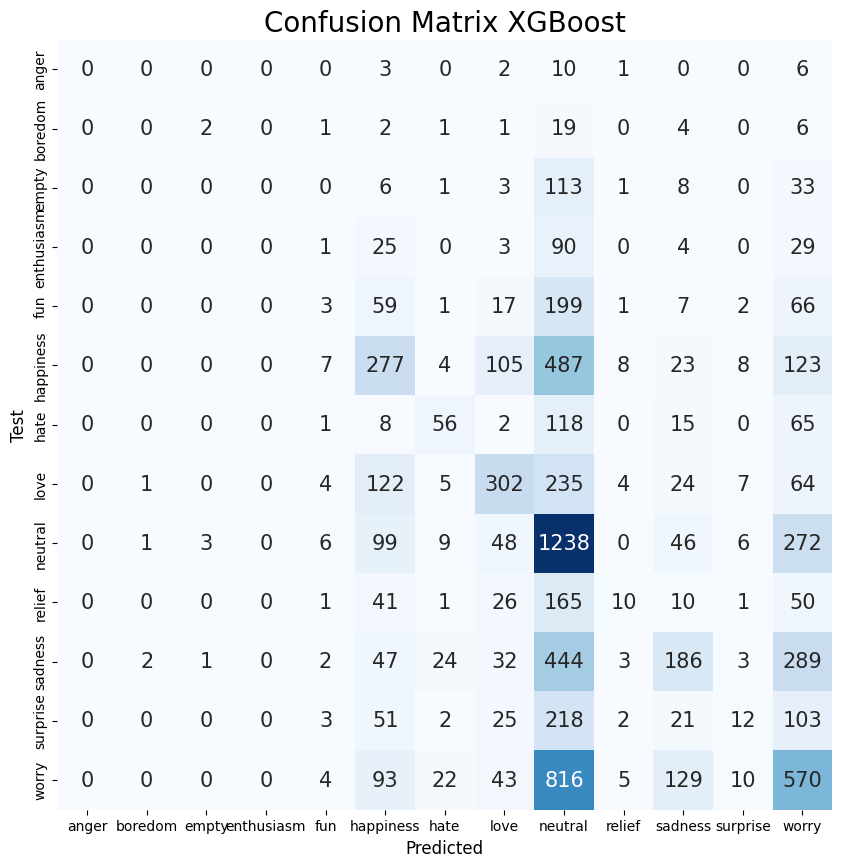

In [ ]:
def XGBoost_Train(X, x, Y, y, l):
    classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        n_estimators= 150,
        max_depth= 5,
        learning_rate= 0.1,
    )
    classifier.fit(X, Y)

    y_pred = classifier.predict(x)

    accuracy_test = classifier.score(x, y)
    accuracy_train = classifier.score(X, Y)

    return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data(data)

accuracy_test, accuracy_train, y, y_pred = XGBoost_Train(X_train, X_test, y_train, y_test, labels)

print('Accuracy on train: {:.2f}%'.format(accuracy_train * 100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test * 100))
print('\nClassification Report:\n', classification_report(y, y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix XGBoost')

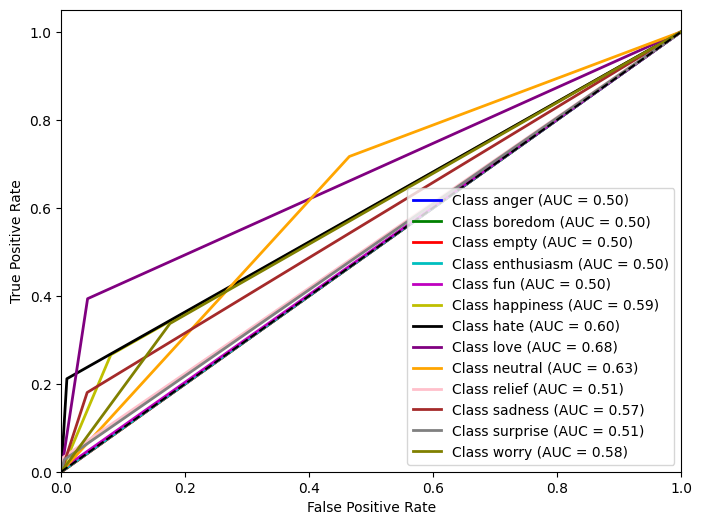

In [ ]:
n_classes = len(labels)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test == i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'pink', 'brown', 'gray', 'olive', 'teal', 'navy']

for i, color in zip(range(n_classes), colors):
    j = label_sentiment_mapping.get(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {j} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## 10.	RMSE Classification Score

Select various choices for size of feature vector and choose alternative feature vectors (to IF-IDF) of your choice, and report the overall RMSE classification score for each class.


In [ ]:
def RandomForest_Train(X, x, Y, y, l):

  classifier= RandomForestClassifier()

  classifier = RandomForestClassifier(criterion = 'gini', n_estimators = 100)
  classifier.fit(X, Y)

  y_pred = classifier.predict(x)

  accuracy_test = classifier.score(x, y)
  accuracy_train = classifier.score(X, Y)

  return accuracy_test, accuracy_train, y, y_pred



In [ ]:
def XGBoost_Train(X, x, Y, y, l):
    classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        n_estimators= 100,
        max_depth= 5,
        learning_rate= 0.1,
    )
    classifier.fit(X, Y)

    y_pred = classifier.predict(x)

    accuracy_test = classifier.score(x, y)
    accuracy_train = classifier.score(X, Y)

    return accuracy_test, accuracy_train, y, y_pred

In [ ]:
def split_data2(data, vectorizer_type, vector_sizes):
  x = np.array(data['content'].values)
  y = np.array(data['sentiment'].values)

  encoder = LabelEncoder()
  y = encoder.fit_transform(y)
  labels = np.unique(encoder.inverse_transform(y))
  label_sentiment_mapping = {label: sentiment for label, sentiment in zip(np.unique(y), np.unique(data['sentiment']))}
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

  if (vectorizer_type == 'tfidf') or (vectorizer_type == 'xgb'):
      tfidf_vectorizer = TfidfVectorizer(max_features=vector_sizes, stop_words='english')
      x_train = tfidf_vectorizer.fit_transform(x_train).toarray()
      x_test = tfidf_vectorizer.transform(x_test).toarray()

  elif vectorizer_type == 'bow':
      vectorizer = CountVectorizer(max_features=vector_sizes)
      x_train = vectorizer.fit_transform(x_train).toarray()
      x_test = vectorizer.transform(x_test).toarray()

  elif vectorizer_type == 'w2v':
      w2v_model = Word2Vec(X_train, vector_size=vector_size, window=5, min_count=1, sg=1)
      x_train = np.array([np.mean([w2v_model.wv[word] for word in doc.split()] if len(doc) > 0 else np.zeros(vector_size), axis=0) for doc in x_train])
      x_test = np.array([np.mean([w2v_model.wv[word] for word in doc.split()] if len(doc) > 0 else np.zeros(vector_size), axis=0) for doc in x_test])


  return x_train, x_test, y_train, y_test, labels, label_sentiment_mapping

---------------------------------
vectorizer_type:  bow
vector_size:  100
---------------------------------
RMSE for sentiment 'anger': 8.168676314267369
RMSE for sentiment 'boredom': 7.222649560006817
RMSE for sentiment 'empty': 7.1257110224705
RMSE for sentiment 'enthusiasm': 5.767992444699044
RMSE for sentiment 'fun': 4.903864529526041
RMSE for sentiment 'happiness': 3.58057780644731
RMSE for sentiment 'hate': 3.4301658466973657
RMSE for sentiment 'love': 2.232279757706607
RMSE for sentiment 'neutral': 2.2199641305076847
RMSE for sentiment 'relief': 2.458841523836838
RMSE for sentiment 'sadness': 2.4869455873235027
RMSE for sentiment 'surprise': 3.5528053182366492
RMSE for sentiment 'worry': 3.8833462697255077
Accuracy on train: 61.07%
Accuracy on test: 27.56%

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.04      0.01     

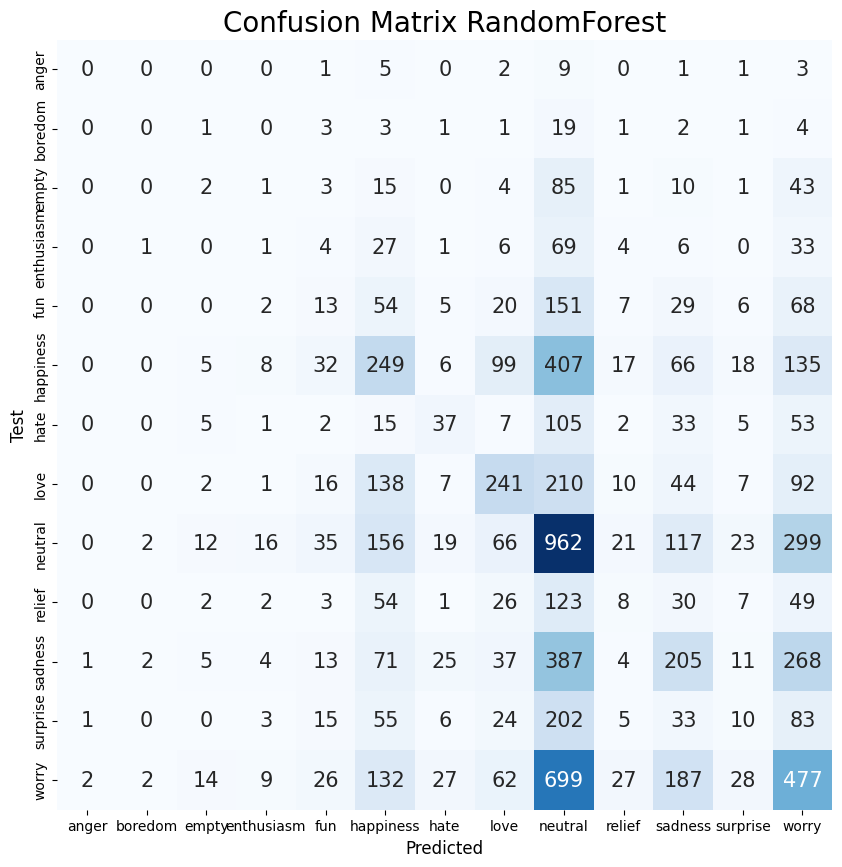

---------------------------------
vectorizer_type:  bow
vector_size:  300
---------------------------------
RMSE for sentiment 'anger': 8.482602516595096
RMSE for sentiment 'boredom': 7.582875444051551
RMSE for sentiment 'empty': 7.0766367632363245
RMSE for sentiment 'enthusiasm': 5.584282454023596
RMSE for sentiment 'fun': 4.939065316148704
RMSE for sentiment 'happiness': 3.6430197762585825
RMSE for sentiment 'hate': 3.7016059747699823
RMSE for sentiment 'love': 2.209414043737992
RMSE for sentiment 'neutral': 2.3372982186625144
RMSE for sentiment 'relief': 2.5103066235546394
RMSE for sentiment 'sadness': 2.521543189811202
RMSE for sentiment 'surprise': 3.4452235366360924
RMSE for sentiment 'worry': 3.7171731041915206
Accuracy on train: 81.68%
Accuracy on test: 28.57%

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.04      0.01

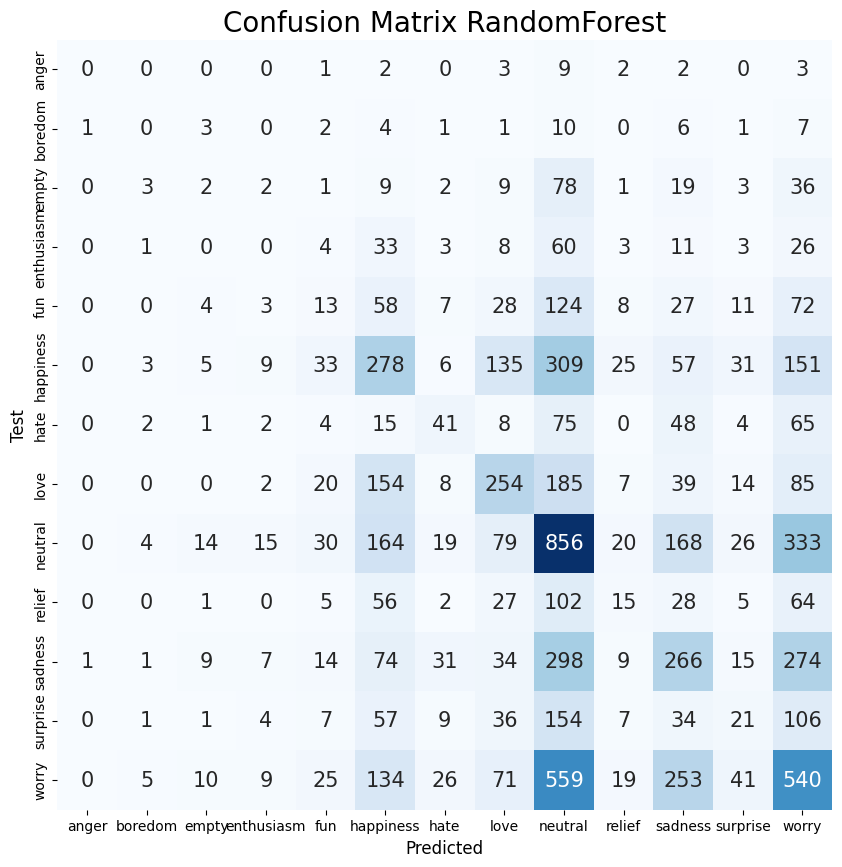

---------------------------------
vectorizer_type:  bow
vector_size:  500
---------------------------------
RMSE for sentiment 'anger': 9.10793859523358
RMSE for sentiment 'boredom': 7.3805299418281765
RMSE for sentiment 'empty': 7.575878786909106
RMSE for sentiment 'enthusiasm': 5.663247162278248
RMSE for sentiment 'fun': 4.908170824764601
RMSE for sentiment 'happiness': 3.6409116995388353
RMSE for sentiment 'hate': 3.7602689586663125
RMSE for sentiment 'love': 2.25
RMSE for sentiment 'neutral': 2.3844839879707496
RMSE for sentiment 'relief': 2.649466386113917
RMSE for sentiment 'sadness': 2.6283140698842664
RMSE for sentiment 'surprise': 3.3659351524949073
RMSE for sentiment 'worry': 3.7166960848627433
Accuracy on train: 87.05%
Accuracy on test: 28.70%

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.03      0.01      0.02    

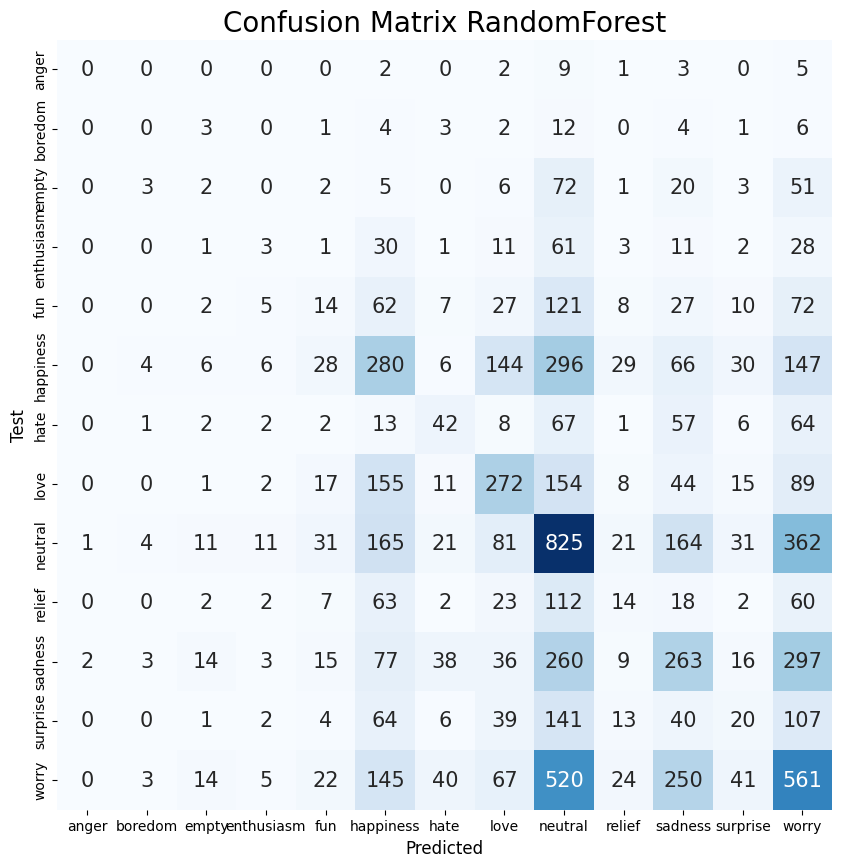

---------------------------------
vectorizer_type:  tfidf
vector_size:  100
---------------------------------
RMSE for sentiment 'anger': 9.055385138137417
RMSE for sentiment 'boredom': 7.664854858377946
RMSE for sentiment 'empty': 7.009085013557242
RMSE for sentiment 'enthusiasm': 5.856283175494415
RMSE for sentiment 'fun': 4.865225846269756
RMSE for sentiment 'happiness': 3.5679582810881367
RMSE for sentiment 'hate': 3.265023331997884
RMSE for sentiment 'love': 2.185415673657226
RMSE for sentiment 'neutral': 2.1209110987707356
RMSE for sentiment 'relief': 2.597602930319905
RMSE for sentiment 'sadness': 2.4036113519996865
RMSE for sentiment 'surprise': 3.5408695876960703
RMSE for sentiment 'worry': 3.755610460241852
Accuracy on train: 56.18%
Accuracy on test: 29.49%

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.04      0.01 

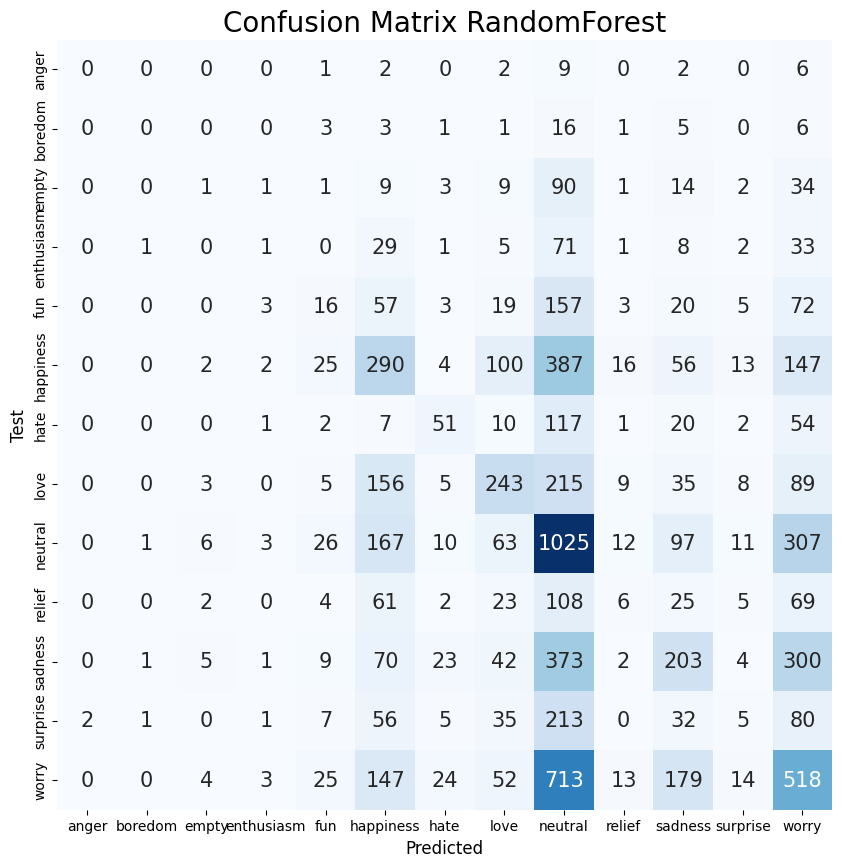

---------------------------------
vectorizer_type:  tfidf
vector_size:  300
---------------------------------
RMSE for sentiment 'anger': 9.112927879965612
RMSE for sentiment 'boredom': 8.498365855987975
RMSE for sentiment 'empty': 7.223278865983064
RMSE for sentiment 'enthusiasm': 5.815134518967228
RMSE for sentiment 'fun': 4.714377171236521
RMSE for sentiment 'happiness': 3.5502966813932195
RMSE for sentiment 'hate': 3.740648717828056
RMSE for sentiment 'love': 2.168668946612184
RMSE for sentiment 'neutral': 2.368045373063804
RMSE for sentiment 'relief': 2.562657432189113
RMSE for sentiment 'sadness': 2.3852158389247506
RMSE for sentiment 'surprise': 3.4607971198562755
RMSE for sentiment 'worry': 3.5780721726669014
Accuracy on train: 76.73%
Accuracy on test: 30.36%

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00 

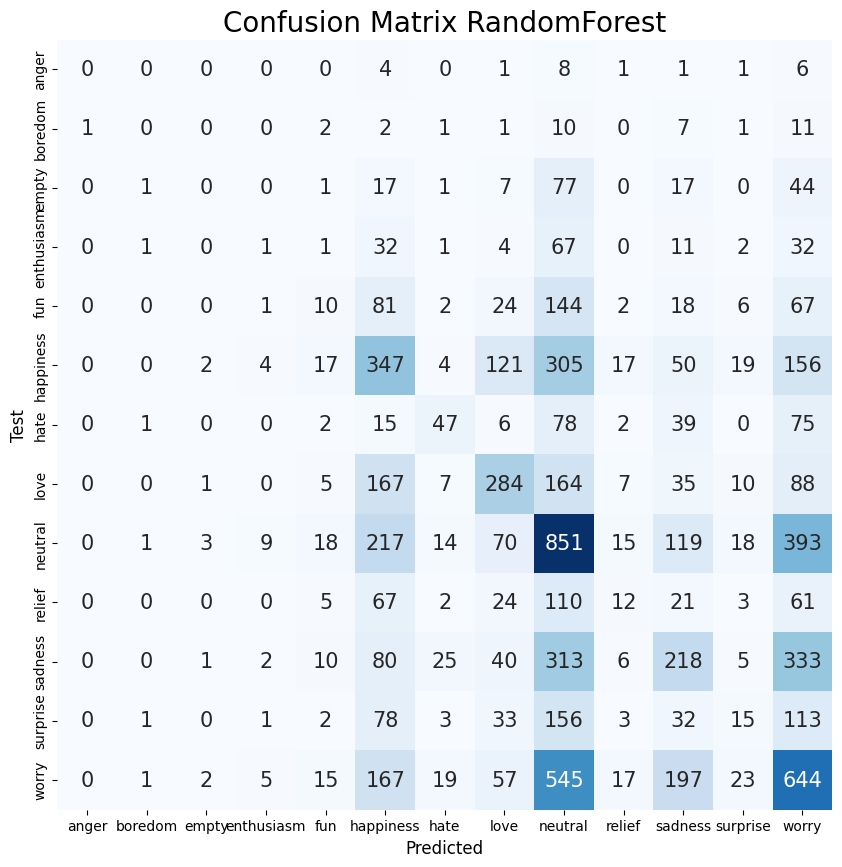

---------------------------------
vectorizer_type:  tfidf
vector_size:  500
---------------------------------
RMSE for sentiment 'anger': 9.020179397530647
RMSE for sentiment 'boredom': 8.036375634160796
RMSE for sentiment 'empty': 7.292586522065966
RMSE for sentiment 'enthusiasm': 5.906619836652503
RMSE for sentiment 'fun': 4.706004555165607
RMSE for sentiment 'happiness': 3.5680927662385247
RMSE for sentiment 'hate': 3.985823936506753
RMSE for sentiment 'love': 2.158136252263358
RMSE for sentiment 'neutral': 2.406227452996818
RMSE for sentiment 'relief': 2.6698068942264377
RMSE for sentiment 'sadness': 2.382576314310632
RMSE for sentiment 'surprise': 3.5589189215490964
RMSE for sentiment 'worry': 3.562677559757416
Accuracy on train: 83.22%
Accuracy on test: 31.13%

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00  

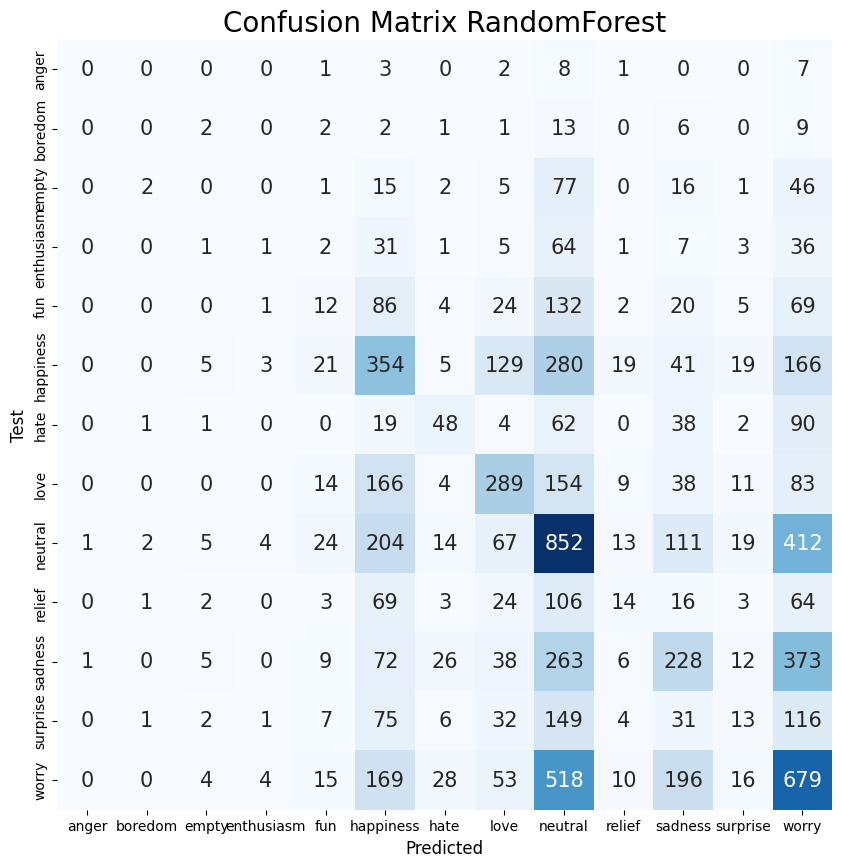

In [ ]:
vectorizer_type = ['bow', 'tfidf']
vector_sizes = [100, 300, 500]
RMSE = {}
for vectorizer_type in vectorizer_type:
    RMSE[vectorizer_type]= {}
    for vector_size in vector_sizes:

        RMSE[vectorizer_type][vector_size]=[]
        X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data2(data, vectorizer_type, vector_size)

        accuracy_test, accuracy_train, y, y_pred = RandomForest_Train(X_train, X_test, y_train, y_test, labels)

        print("---------------------------------")
        print("vectorizer_type: ", vectorizer_type)
        print("vector_size: ", vector_size)
        print("---------------------------------")

        rmse_scores = []
        for sentiment in labels:
            label = [key for key, value in label_sentiment_mapping.items() if value == sentiment][0]
            label_indices = np.where(y_test == label)[0]
            rmse = np.sqrt(mean_squared_error(y_test[label_indices], y_pred[label_indices]))
            rmse_scores.append((sentiment, rmse))

            print(f"RMSE for sentiment '{sentiment}': {rmse}")

        RMSE[vectorizer_type][vector_size].append(rmse_scores)
        print('Accuracy on train: {:.2f}%'.format(accuracy_train * 100))
        print('Accuracy on test: {:.2f}%'.format(accuracy_test * 100))

        print('\nClassification Report:\n')
        report = classification_report(y, y_pred, target_names=[str(l) for l in labels])
        print(report)

        conf_matrix(y, y_pred, labels, 'Confusion Matrix RandomForest')

In [ ]:
flattened_data = []

for vectorizer_type, vector_size_data in RMSE.items():
    for vector_size, sentiment_data in vector_size_data.items():
        for i in sentiment_data:
          for j in range(13):
            flattened_data.append({
                'vectorizer_type': vectorizer_type,
                'vector_size': vector_size,
                'sentiment_category': i[j][0],
                'RMSE': i[j][1]
            })

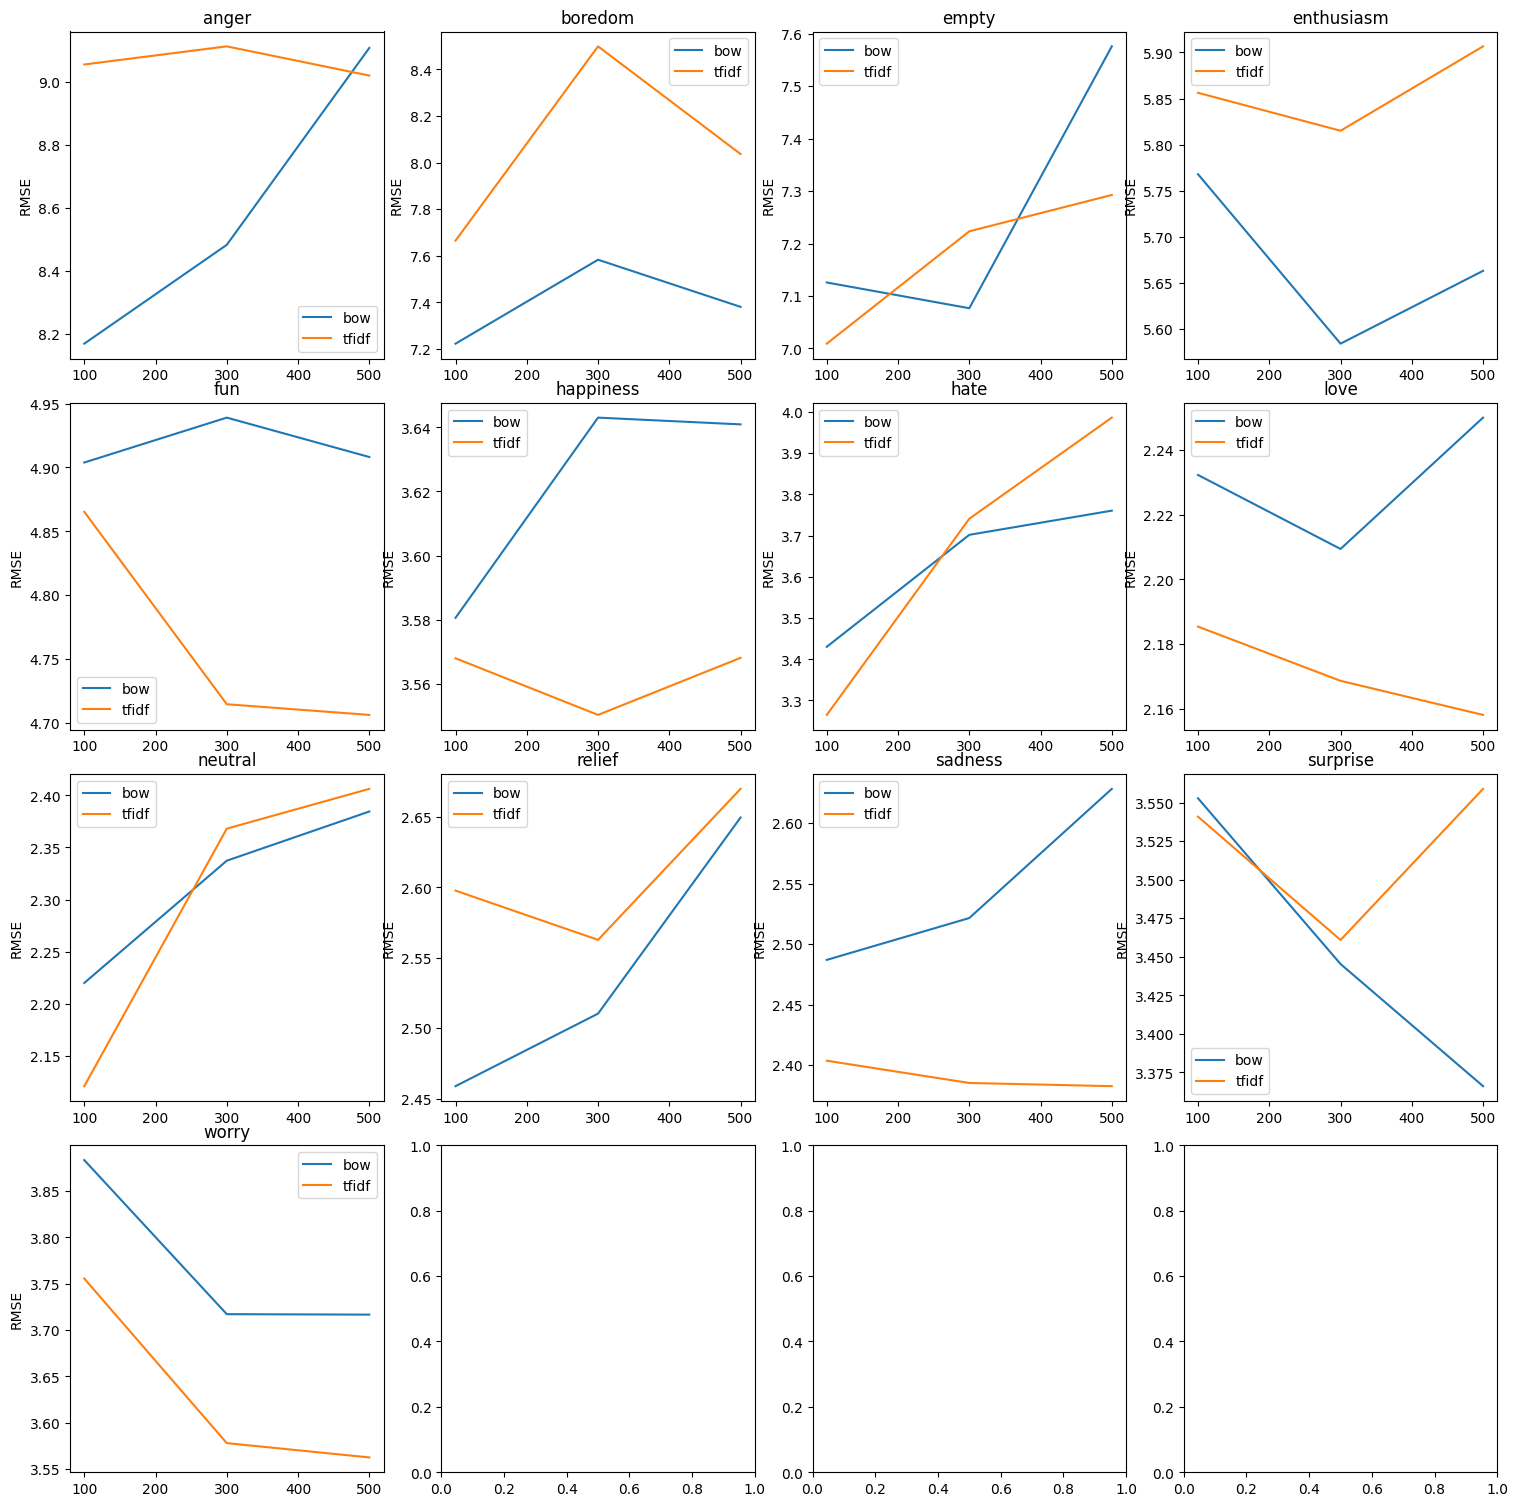

In [ ]:

sentiment_categories = [emotion[0] for emotion in rmse_scores]

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.tight_layout()

for i, sentiment_category in enumerate(sentiment_categories):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    data_subset = [d for d in flattened_data if d['sentiment_category'] == sentiment_category]

    for vectorizer_type in set(d['vectorizer_type'] for d in data_subset):
        x = [d['vector_size'] for d in data_subset if d['vectorizer_type'] == vectorizer_type]
        y = [d['RMSE'] for d in data_subset if d['vectorizer_type'] == vectorizer_type]

        ax.plot(x, y, label=vectorizer_type)

    ax.set_title(sentiment_category)
    ax.set_ylabel('RMSE')
    ax.legend()

plt.show()

In [ ]:
df = pd.DataFrame(flattened_data)
best_combinations = df.groupby('sentiment_category').apply(lambda x: x.loc[x['RMSE'].idxmin()])
best_combinations = best_combinations.reset_index(drop=True)

In [ ]:
category_counts = data['sentiment'].value_counts()

In [ ]:
best_combinations

vectorizer_type  vector_size sentiment_category      RMSE
0              bow          100              anger  8.168676
1              bow          100            boredom  7.222650
2            tfidf          100              empty  7.009085
3              bow          300         enthusiasm  5.584282
4            tfidf          500                fun  4.706005
5            tfidf          300          happiness  3.550297
6            tfidf          100               hate  3.265023
7            tfidf          500               love  2.158136
8            tfidf          100            neutral  2.120911
9              bow          100             relief  2.458842
10           tfidf          500            sadness  2.382576
11             bow          500           surprise  3.365935
12           tfidf          500              worry  3.562678

In [ ]:
best_combinations['RMSE_normalized'] = best_combinations['sentiment_category'].map(category_counts)
best_combinations['RMSE_normalized'] = best_combinations['RMSE'] / best_combinations['RMSE_normalized']
best_combinations['Number_of_tweets'] = best_combinations['sentiment_category'].map(category_counts)
df_ordinato = best_combinations.sort_values(by='RMSE_normalized')

In [ ]:
df_ordinato

vectorizer_type  vector_size sentiment_category      RMSE  RMSE_normalized  \
8            tfidf          100            neutral  2.120911         0.000246   
12           tfidf          500              worry  3.562678         0.000421   
10           tfidf          500            sadness  2.382576         0.000461   
7            tfidf          500               love  2.158136         0.000562   
5            tfidf          300          happiness  3.550297         0.000682   
11             bow          500           surprise  3.365935         0.001539   
9              bow          100             relief  2.458842         0.001611   
6            tfidf          100               hate  3.265023         0.002468   
4            tfidf          500                fun  4.706005         0.002650   
3              bow          300         enthusiasm  5.584282         0.007357   
2            tfidf          100              empty  7.009085         0.008475   
1              bow          100            boredom  7.222650         0.040350   
0              bow          100              anger  8.168676         0.074261   

    Number_of_tweets  
8               8638  
12              8459  
10              5165  
7               3842  
5               5209  
11              2187  
9               1526  
6               1323  
4               1776  
3                759  
2                827  
1                179  
0                110

## 11. Classification Rate with Deletion
We want to find out whether a change in category design can influence the results. For this purpose, delete the categories that possess a relatively small number of samples from the classification scheme. Then, repeat 9) and determine the new classification rate for each category.




38952


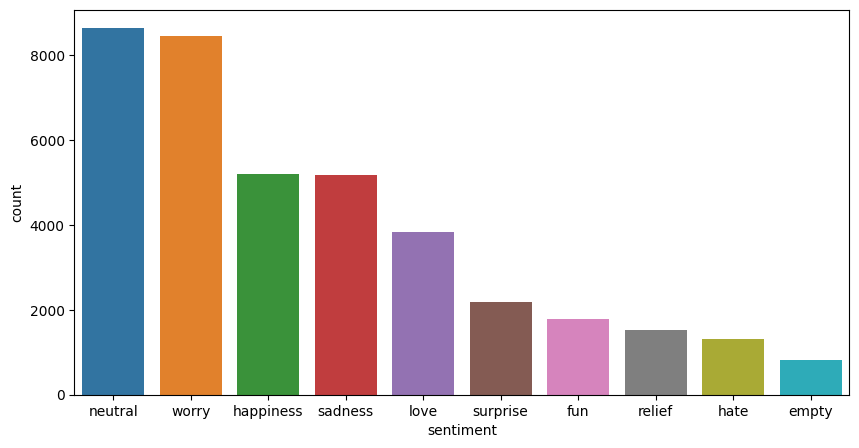

In [ ]:
num_categories = 3

category_counts = data['sentiment'].value_counts()
categories_to_exclude = category_counts.tail(num_categories).index
df_reduce_1 = data[~data['sentiment'].isin(categories_to_exclude)]

print(df_reduce_1.shape[0])
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='sentiment', data=df_reduce_1, order=df_reduce_1['sentiment'].value_counts().index)
plt.show()


---------------------------------
vectorizer_type:  tfidf
vectori_sizes:  500
---------------------------------
RMSE Score: 3.137195750384248
Accuracy on train: 83.40%
Accuracy on test: 32.42%

Classification Report:

               precision    recall  f1-score   support

       empty       0.00      0.00      0.00       165
         fun       0.10      0.03      0.05       355
   happiness       0.31      0.35      0.33      1042
        hate       0.38      0.17      0.23       265
        love       0.45      0.38      0.41       769
     neutral       0.33      0.51      0.40      1728
      relief       0.09      0.02      0.04       305
     sadness       0.29      0.20      0.24      1033
    surprise       0.14      0.04      0.06       437
       worry       0.33      0.40      0.36      1692

    accuracy                           0.32      7791
   macro avg       0.24      0.21      0.21      7791
weighted avg       0.30      0.32      0.30      7791



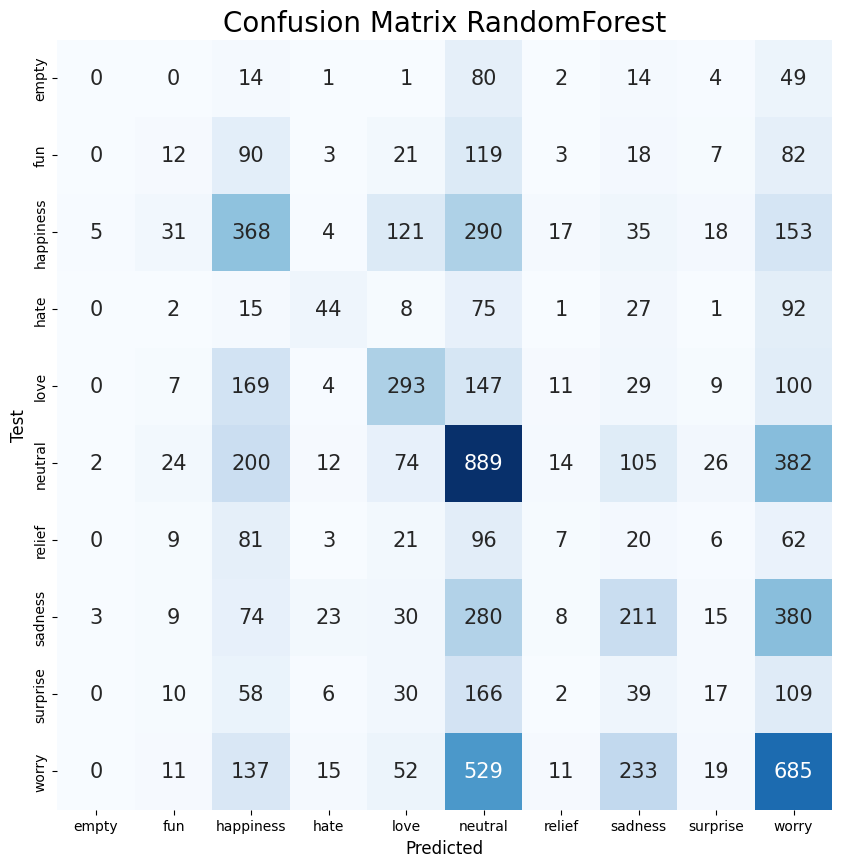

---------------------------------
vectorizer_type:  xgb
vectori_sizes:  500
---------------------------------
RMSE Score: 2.9534965865941825
Accuracy on train: 39.42%
Accuracy on test: 33.59%

Classification Report:

               precision    recall  f1-score   support

       empty       0.00      0.00      0.00       165
         fun       0.22      0.02      0.03       355
   happiness       0.35      0.28      0.31      1042
        hate       0.42      0.19      0.26       265
        love       0.51      0.38      0.43       769
     neutral       0.30      0.73      0.43      1728
      relief       0.26      0.03      0.05       305
     sadness       0.40      0.16      0.23      1033
    surprise       0.37      0.03      0.06       437
       worry       0.34      0.32      0.33      1692

    accuracy                           0.34      7791
   macro avg       0.32      0.21      0.21      7791
weighted avg       0.35      0.34      0.30      7791



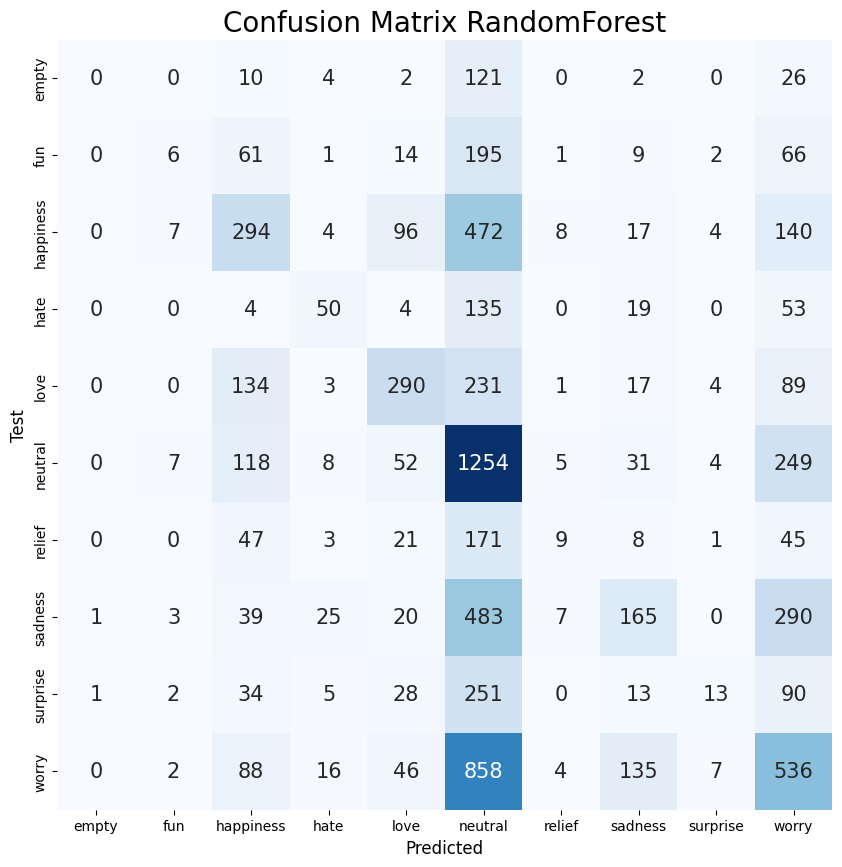

In [ ]:
vectorizer_type = ['tfidf', 'xgb']
vector_sizes = [500]

for vectorizer_type in vectorizer_type:
  for vector_size in vector_sizes:
    X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data2(df_reduce_1, vectorizer_type, vector_size)

    if (vectorizer_type =='tfidf'):
      accuracy_test, accuracy_train, y, y_pred = RandomForest_Train(X_train, X_test, y_train, y_test, labels)
    elif vectorizer_type == 'xgb':
      accuracy_test, accuracy_train, y, y_pred = XGBoost_Train(X_train, X_test, y_train, y_test, labels)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("---------------------------------")
    print("vectorizer_type: ", vectorizer_type)
    print("vectori_sizes: ", vector_size)
    print("---------------------------------")
    print(f"RMSE Score: {rmse}")

    print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
    print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
    print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
    conf_matrix(y, y_pred, labels, 'Confusion Matrix RandomForest')

## 12.	Classification Rate with Merging
Repeat 11 by merging the categories of small sample into a single meta-category, and repeat 11) accordingly.


All right


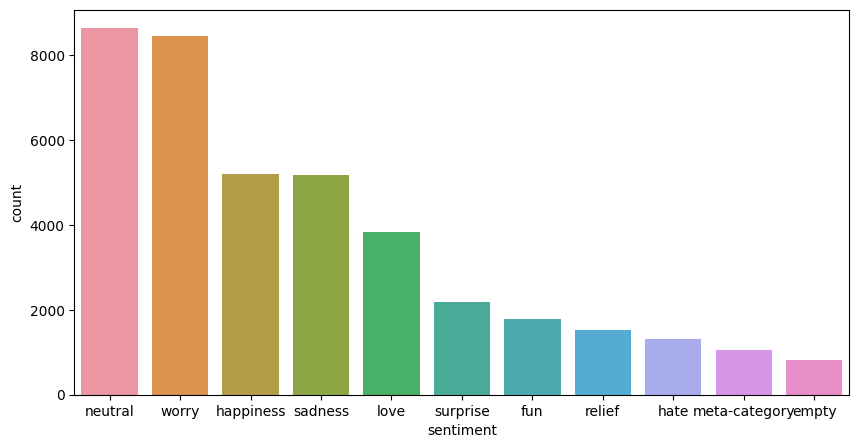

In [ ]:
categories_to_merge = category_counts.tail(num_categories).index
new_category_name = "meta-category"

df_reduce_2 = data.copy()
df_reduce_2['sentiment'] = df_reduce_2['sentiment'].apply(lambda x: new_category_name if x in categories_to_merge else x)

if df_reduce_2.shape[0] == 40000: print('All right')

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='sentiment', data=df_reduce_2, order=df_reduce_2['sentiment'].value_counts().index)
plt.show()

---------------------------------
vectorizer_type:  tfidf
vectori_sizes:  500
---------------------------------
RMSE Score: 3.6089298967976644
Accuracy on train: 83.03%
Accuracy on test: 31.16%

Classification Report:

                precision    recall  f1-score   support

        empty       0.00      0.00      0.00       165
          fun       0.14      0.04      0.06       355
    happiness       0.28      0.34      0.31      1042
         hate       0.35      0.16      0.22       265
         love       0.43      0.38      0.40       768
meta-category       0.04      0.00      0.01       210
      neutral       0.31      0.48      0.38      1728
       relief       0.15      0.04      0.07       305
      sadness       0.30      0.21      0.25      1033
     surprise       0.11      0.03      0.05       437
        worry       0.32      0.42      0.37      1692

     accuracy                           0.31      8000
    macro avg       0.22      0.19      0.19      8000
 weighte

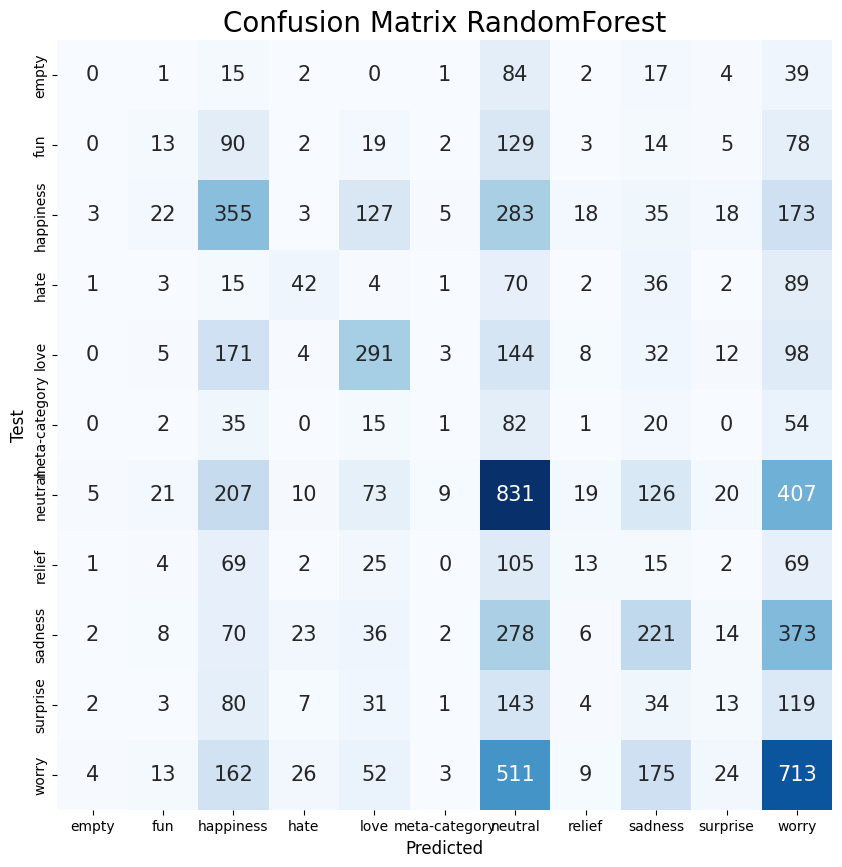

---------------------------------
vectorizer_type:  xgb
vectori_sizes:  500
---------------------------------
RMSE Score: 3.3267288738338747
Accuracy on train: 38.17%
Accuracy on test: 32.95%

Classification Report:

                precision    recall  f1-score   support

        empty       0.00      0.00      0.00       165
          fun       0.20      0.02      0.03       355
    happiness       0.35      0.27      0.31      1042
         hate       0.43      0.20      0.28       265
         love       0.48      0.37      0.42       768
meta-category       0.00      0.00      0.00       210
      neutral       0.29      0.73      0.42      1728
       relief       0.32      0.03      0.06       305
      sadness       0.41      0.17      0.24      1033
     surprise       0.32      0.03      0.06       437
        worry       0.34      0.32      0.33      1692

     accuracy                           0.33      8000
    macro avg       0.29      0.20      0.19      8000
 weighted 

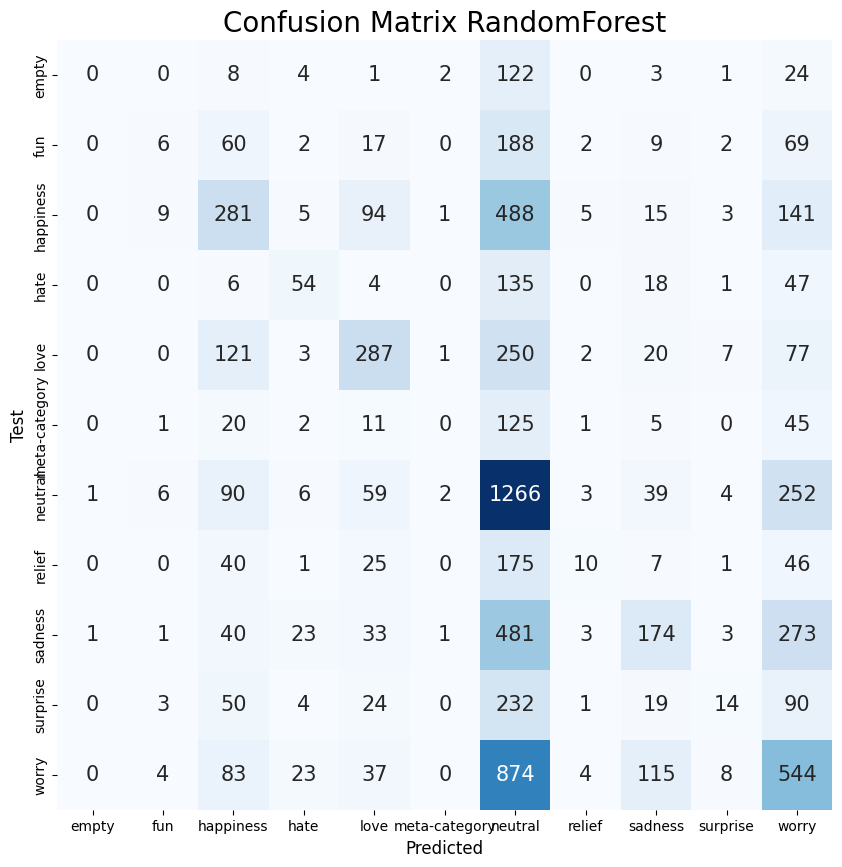

In [ ]:
vectorizer_type = ['tfidf', 'xgb']
vector_sizes = [500]

for vectorizer_type in vectorizer_type:
  for vector_size in vector_sizes:
    X_train, X_test, y_train, y_test, labels, label_sentiment_mapping = split_data2(df_reduce_2, vectorizer_type, vector_size)
    if (vectorizer_type =='tfidf'):
      accuracy_test, accuracy_train, y, y_pred = RandomForest_Train(X_train, X_test, y_train, y_test, labels)
    elif vectorizer_type == 'xgb':
      accuracy_test, accuracy_train, y, y_pred = XGBoost_Train(X_train, X_test, y_train, y_test, labels)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("---------------------------------")
    print("vectorizer_type: ", vectorizer_type)
    print("vectori_sizes: ", vector_size)
    print("---------------------------------")
    print(f"RMSE Score: {rmse}")

    print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
    print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
    print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
    conf_matrix(y, y_pred, labels, 'Confusion Matrix RandomForest')